# ***Scratch Implementation of Faster R-CNN***</center>


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
import cv2
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import zipfile

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Device: Tesla T4
Using device: cuda


## 1) Download + Extract GTSDB from Kaggle

In [5]:
import os
import zipfile
from google.colab import files

# Kaggle setup
!mkdir -p ~/.kaggle

print("Upload kaggle.json:")
uploaded = files.upload()

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
print("Downloading GTSDB dataset...")
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb

# Extract dataset
print("Extracting...")
with zipfile.ZipFile('german-traffic-sign-detection-benchmark-gtsdb.zip', 'r') as f:
    f.extractall('gtsdb_data')

print("Dataset ready!")


Upload kaggle.json:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
License(s): unknown
 97% 1.56G/1.61G [01:01<00:03, 15.4MB/s]
100% 1.61G/1.61G [01:01<00:00, 28.2MB/s]
Extracting...
Dataset ready!


## 2) Define Dataset Paths

In [6]:
DATASET_ROOT = "gtsdb_data"

TRAIN_DIR = os.path.join(DATASET_ROOT, "TrainIJCNN2013", "TrainIJCNN2013")
TEST_DIR  = os.path.join(DATASET_ROOT, "TestIJCNN2013", "TestIJCNN2013Download")

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)


TRAIN_DIR: gtsdb_data/TrainIJCNN2013/TrainIJCNN2013
TEST_DIR: gtsdb_data/TestIJCNN2013/TestIJCNN2013Download


## 3) Inspect Directories

In [7]:
print("\nChecking dataset structure...\n")

if os.path.exists(TRAIN_DIR):
    train_files = sorted([f for f in os.listdir(TRAIN_DIR) if f.endswith(".ppm")])
    print(f"Train images: {len(train_files)}")
    print("First 5 train images:", train_files[:5])
else:
    print(" TRAIN directory not found!")

if os.path.exists(TEST_DIR):
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(".ppm")])
    print(f"Test images: {len(test_files)}")
    print("First 5 test images:", test_files[:5])
else:
    print(" TEST directory not found!")



Checking dataset structure...

Train images: 600
First 5 train images: ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm']
Test images: 300
First 5 test images: ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm']


## 4) Dataset Class (CLEAN)

In [8]:
class GTSDBDataset(Dataset):
    def __init__(self, root_dir, transforms=None, indices=None):
        """
        root_dir : folder containing images and gt.txt
        transforms: albumentations.Compose or None
        indices  : list/array of indices to keep (optional)
        """
        self.root_dir = root_dir
        self.transforms = transforms

        # Build annotations dict: image_name -> boxes/labels
        annotations = {}
        gt_file = os.path.join(root_dir, "gt.txt")
        if not os.path.exists(gt_file):
            raise FileNotFoundError("gt.txt not found in: " + root_dir)

        with open(gt_file, "r") as f:
            for line in f:
                parts = line.strip().split(";")
                img_name = parts[0]
                x1, y1, x2, y2 = map(int, parts[1:5])
                cls = int(parts[5]) + 1  # keep +1 if dataset labels are 0-indexed

                if img_name not in annotations:
                    annotations[img_name] = {"boxes": [], "labels": []}

                annotations[img_name]["boxes"].append([x1, y1, x2, y2])
                annotations[img_name]["labels"].append(cls)

        # Build ordered lists
        self.images = []
        self.targets = []
        for img_name, ann in sorted(annotations.items()):
            img_path = os.path.join(root_dir, img_name)
            if not os.path.exists(img_path):
                continue

            self.images.append(img_path)
            boxes = torch.tensor(ann["boxes"], dtype=torch.float32)
            labels = torch.tensor(ann["labels"], dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            self.targets.append({
                "boxes": boxes,
                "labels": labels,
                "area": area,
                "iscrowd": iscrowd,
            })

        # Optionally subset by indices
        if indices is not None:
            self.images = [self.images[i] for i in indices]
            self.targets = [self.targets[i] for i in indices]

        print(f" Loaded {len(self.images)} images with bounding boxes. (transforms={'yes' if transforms else 'no'})")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        target = self.targets[idx].copy()

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes = target["boxes"].numpy().astype(float).tolist()
        labels = target["labels"].numpy().tolist()

        if self.transforms:
            augmented = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = augmented['image']
            boxes = augmented['bboxes']
            labels = augmented['labels']
        else:
            img = img

        img = torch.from_numpy(img).permute(2,0,1).float() / 255.0

        boxes_t = torch.tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0,4), dtype=torch.float32)
        labels_t = torch.tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes_t,
            "labels": labels_t,
            "area": (boxes_t[:,2] - boxes_t[:,0]) * (boxes_t[:,3] - boxes_t[:,1]) if boxes_t.numel() else torch.zeros((0,)),
            "iscrowd": torch.zeros((len(labels_t),), dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        return img, target


## 5) Create Dataset + DataLoader

In [9]:
dataset = GTSDBDataset("/content/gtsdb_data/TrainIJCNN2013/TrainIJCNN2013")
print("Total images:", len(dataset))


 Loaded 506 images with bounding boxes. (transforms=no)
Total images: 506


In [10]:
dataset = GTSDBDataset(root_dir=TRAIN_DIR)

print(f"Total samples in dataset: {len(dataset)}")

 Loaded 506 images with bounding boxes. (transforms=no)
Total samples in dataset: 506


# 6) Data visualization

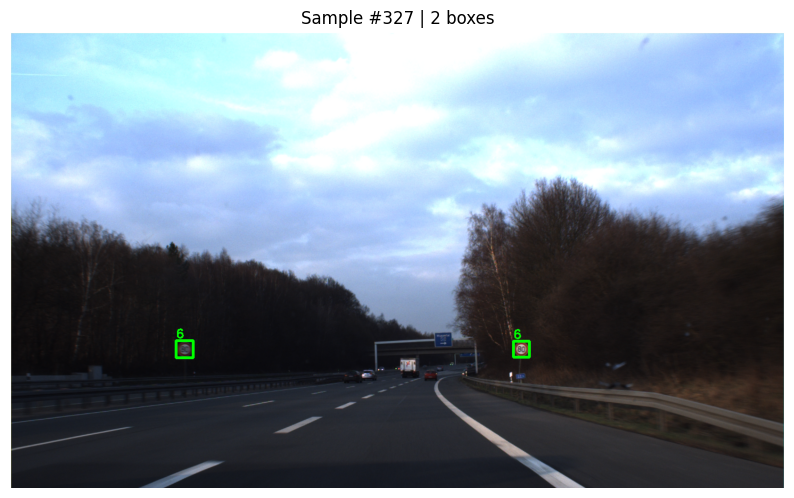

In [11]:
import random
import matplotlib.pyplot as plt
import cv2

def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)

    img, target = dataset[idx]

    img_np = img.permute(1, 2, 0).numpy().copy()
    img_np = (img_np * 255).astype("uint8")

    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    img_draw = img_np.copy()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0,255,0), 3)
        cv2.putText(img_draw, str(label), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    plt.figure(figsize=(10, 7))
    plt.imshow(img_draw)
    plt.title(f"Sample #{idx} | {len(boxes)} boxes")
    plt.axis("off")
    plt.show()

# RUN IT
visualize_random_sample(dataset)


In [13]:
!pip install -q albumentations==1.3.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 12.1 MB/s eta 0:00:00


# 7) Data Augmentation

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import cv2

# define augmentation pipeline (will transform both image and boxes)
train_aug = A.Compose([
    A.Rotate(limit=8, p=0.3),                  # small rotation
    A.RandomBrightnessContrast(p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))



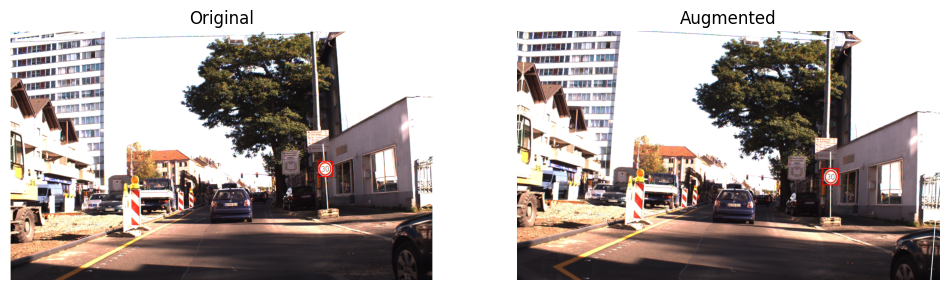

In [15]:
import matplotlib.pyplot as plt
import random
import cv2

def draw_boxes_on_np(img_np, boxes, labels, color=(255,0,0)):
    out = img_np.copy()
    for (x1,y1,x2,y2), lbl in zip(boxes, labels):
        cv2.rectangle(out, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        cv2.putText(out, str(int(lbl)), (int(x1), int(max(0,y1-5))), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return out

# show one example before/after
idx = random.randint(0, len(dataset)-1)
img_path = dataset.images[idx]
orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
boxes = dataset.targets[idx]['boxes'].numpy()
labels = dataset.targets[idx]['labels'].numpy()

# apply albumentations transform directly for visualization
aug = train_aug(image=orig, bboxes=boxes.tolist(), labels=labels.tolist())
img_aug = aug['image']; boxes_aug = aug['bboxes']; labels_aug = aug['labels']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(draw_boxes_on_np(orig, boxes, labels))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Augmented')
plt.imshow(draw_boxes_on_np(img_aug, boxes_aug, labels_aug))
plt.axis('off')

plt.show()


# 8)Create a reproducible train/val split and datasets with different transforms

In [16]:
# Prepare a full dataset object (no transforms) just to get length / index mapping
full_dataset = GTSDBDataset(root_dir=TRAIN_DIR, transforms=None)

num_samples = len(full_dataset)
all_indices = list(range(num_samples))

# reproducible split
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=seed, shuffle=True)

print(f"Total samples: {num_samples} | Train: {len(train_idx)} | Val: {len(val_idx)}")

# Create dataset objects that point to same underlying annotations but different transforms
train_dataset = GTSDBDataset(root_dir=TRAIN_DIR, transforms=train_aug, indices=train_idx)
val_dataset   = GTSDBDataset(root_dir=TRAIN_DIR, transforms=None,      indices=val_idx)

# DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, collate_fn=collate_fn)


 Loaded 506 images with bounding boxes. (transforms=no)
Total samples: 506 | Train: 404 | Val: 102
 Loaded 404 images with bounding boxes. (transforms=yes)
 Loaded 102 images with bounding boxes. (transforms=no)


# 9) Quick visual check to confirm augmentation is applied only to train_dataset

Random train sample:
Random val sample:


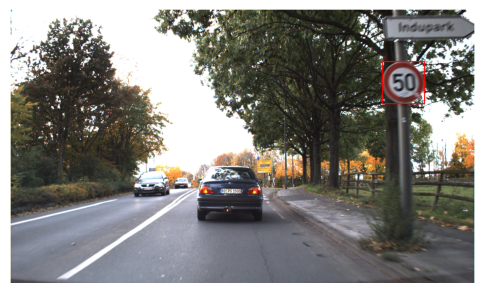

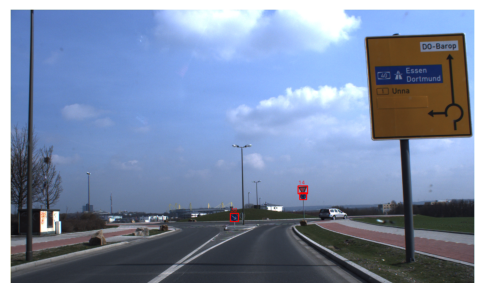

In [17]:
# visualize one train sample and one val sample
def show_sample_from_dataset(ds, idx):
    img, target = ds[idx]
    img_np = img.permute(1,2,0).numpy()
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(draw_boxes_on_np((img_np*255).astype('uint8'), boxes, labels))
    plt.axis('off')

print("Random train sample:")
show_sample_from_dataset(train_dataset, random.randint(0, len(train_dataset)-1))

print("Random val sample:")
show_sample_from_dataset(val_dataset, random.randint(0, len(val_dataset)-1))


## SECTION 1: Custom ResNet Backbone Wrapper

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
from torchvision.ops import boxes as box_ops

# SECTION 1: BACKBONE (ResNet50 Wrapper)

class ResNetBackbone(nn.Module):
    """
    Wrap ResNet50 to output multi-scale feature maps (C2-C5)
    """
    def __init__(self, pretrained=True):
        super().__init__()

        resnet = torchvision.models.resnet50(weights="IMAGENET1K_V2" if pretrained else None)

        self.stem = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )

        self.layer1 = resnet.layer1  # C2 (stride 4)
        self.layer2 = resnet.layer2  # C3 (stride 8)
        self.layer3 = resnet.layer3  # C4 (stride 16)
        self.layer4 = resnet.layer4  # C5 (stride 32)

        self.out_channels = {
            'c2': 256,
            'c3': 512,
            'c4': 1024,
            'c5': 2048
        }

    def forward(self, x):
        x = self.stem(x)
        c2 = self.layer1(x)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return {
            'c2': c2,
            'c3': c3,
            'c4': c4,
            'c5': c5
        }

print(" Section 1: Custom Backbone defined")


 Section 1: Custom Backbone defined


## SECTION 2: Custom FPN (Neck)

In [19]:
# SECTION 2: CUSTOM FPN (NECK)

class CustomFPN(nn.Module):
    """
    Custom Feature Pyramid Network
    """
    def __init__(self, in_channels_list=[256, 512, 1024, 2048], out_channels=256):
        super().__init__()

        self.out_channels = out_channels

        # Lateral convs
        self.lateral_c5 = nn.Conv2d(in_channels_list[3], out_channels, 1)
        self.lateral_c4 = nn.Conv2d(in_channels_list[2], out_channels, 1)
        self.lateral_c3 = nn.Conv2d(in_channels_list[1], out_channels, 1)
        self.lateral_c2 = nn.Conv2d(in_channels_list[0], out_channels, 1)

        # Smoothing convs
        self.smooth_p5 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.smooth_p4 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.smooth_p3 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.smooth_p2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        # P6 for RPN
        self.p6_conv = nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, features):
        c2, c3, c4, c5 = features['c2'], features['c3'], features['c4'], features['c5']

        # Top-down pathway
        p5 = self.lateral_c5(c5)
        p4 = self.lateral_c4(c4) + F.interpolate(p5, size=c4.shape[-2:], mode='nearest')
        p3 = self.lateral_c3(c3) + F.interpolate(p4, size=c3.shape[-2:], mode='nearest')
        p2 = self.lateral_c2(c2) + F.interpolate(p3, size=c2.shape[-2:], mode='nearest')

        # Smoothing
        p5 = self.smooth_p5(p5)
        p4 = self.smooth_p4(p4)
        p3 = self.smooth_p3(p3)
        p2 = self.smooth_p2(p2)

        # P6
        p6 = self.p6_conv(p5)

        return {
            'p2': p2,
            'p3': p3,
            'p4': p4,
            'p5': p5,
            'p6': p6
        }

print(" Section 2: Custom FPN defined")


 Section 2: Custom FPN defined


##  SECTION 3: Custom RPN Head

In [20]:
# SECTION 3: CUSTOM RPN HEAD

class CustomRPNHead(nn.Module):
    """
    Region Proposal Network Head
    """
    def __init__(self, in_channels=256, num_anchors=3):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.objectness = nn.Conv2d(in_channels, num_anchors * 1, 1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, 1)

        for layer in [self.conv, self.objectness, self.bbox_pred]:
            nn.init.normal_(layer.weight, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, features):
        objectness = []
        bbox_reg = []

        for feature in features:
            t = F.relu(self.conv(feature))
            objectness.append(self.objectness(t))
            bbox_reg.append(self.bbox_pred(t))

        return objectness, bbox_reg



print(" Section 3: Custom RPN Head defined")


 Section 3: Custom RPN Head defined


## SECTION 4: Custom ROI Heads

In [21]:
# SECTION 4: CUSTOM ROI HEADS

class CustomROIHeads(nn.Module):
    """
    ROI Heads for final detection
    """
    def __init__(self, in_channels=256, num_classes=44, representation_size=1024):
        super().__init__()

        from torchvision.ops import MultiScaleRoIAlign
        self.roi_align = MultiScaleRoIAlign(
            featmap_names=['p2', 'p3', 'p4', 'p5'],
            output_size=7,
            sampling_ratio=2
        )

        self.fc1 = nn.Linear(in_channels * 7 * 7, representation_size)
        self.fc2 = nn.Linear(representation_size, representation_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

        self.cls_score = nn.Linear(representation_size, num_classes)
        self.bbox_pred = nn.Linear(representation_size, num_classes * 4)

        self._init_weights()

    def _init_weights(self):
        for m in [self.fc1, self.fc2, self.cls_score, self.bbox_pred]:
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(self, features, proposals, image_shapes):
        box_features = self.roi_align(features, proposals, image_shapes)
        box_features = box_features.flatten(start_dim=1)

        x = F.relu(self.fc1(box_features))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        class_logits = self.cls_score(x)
        box_regression = self.bbox_pred(x)

        return class_logits, box_regression


print(" Section 4: Custom ROI Heads defined")


 Section 4: Custom ROI Heads defined


## SECTION 5: Complete Faster R-CNN Model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops

class CustomFasterRCNN(nn.Module):
    """Complete Faster R-CNN with FIXED NaN prevention"""

    def __init__(self, num_classes=44, pretrained_backbone=True):
        super().__init__()

        self.backbone = ResNetBackbone(pretrained=pretrained_backbone)
        self.fpn = CustomFPN(
            in_channels_list=[256, 512, 1024, 2048],
            out_channels=256
        )
        self.rpn_head = CustomRPNHead(in_channels=256, num_anchors=3)

        from torchvision.models.detection.rpn import AnchorGenerator as TorchAnchorGenerator
        self.anchor_generator = TorchAnchorGenerator(
            sizes=((32,), (64,), (128,), (256,), (512,)),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )

        self.roi_heads = CustomROIHeads(
            in_channels=256,
            num_classes=num_classes,
            representation_size=1024
        )

        self.num_classes = num_classes
        self.rpn_pre_nms_top_n_train = 2000
        self.rpn_pre_nms_top_n_test = 1000
        self.rpn_post_nms_top_n_train = 2000
        self.rpn_post_nms_top_n_test = 1000
        self.rpn_nms_thresh = 0.7
        self.rpn_fg_iou_thresh = 0.7
        self.rpn_bg_iou_thresh = 0.3
        self.box_score_thresh = 0.05
        self.box_nms_thresh = 0.5
        self.box_detections_per_img = 100
        self.box_fg_iou_thresh = 0.5
        self.box_bg_iou_thresh = 0.5

    def forward(self, images, targets=None):
        if isinstance(images, list):
            original_image_sizes = [tuple(img.shape[-2:]) for img in images]
            images = torch.stack(images)
        else:
            original_image_sizes = [tuple(images.shape[-2:])] * images.shape[0]

        backbone_features = self.backbone(images)
        fpn_features = self.fpn(backbone_features)

        fpn_list = [fpn_features['p2'], fpn_features['p3'], fpn_features['p4'],
                    fpn_features['p5'], fpn_features['p6']]

        objectness, bbox_deltas = self.rpn_head(fpn_list)

        from torchvision.models.detection.image_list import ImageList
        image_list = ImageList(images, original_image_sizes)
        anchors = self.anchor_generator(image_list, fpn_list)

        proposals = self._generate_proposals(
            objectness, bbox_deltas, anchors, original_image_sizes
        )

        if self.training and targets is not None:
            proposals, matched_idxs, labels, regression_targets = self._select_training_samples(
                proposals, targets
            )
        else:
            labels = None
            regression_targets = None

        class_logits, box_regression = self.roi_heads(
            fpn_features, proposals, original_image_sizes
        )

        if self.training:
            losses = self._compute_losses(
                objectness, bbox_deltas, anchors, class_logits,
                box_regression, labels, regression_targets, targets, original_image_sizes
            )
            return losses
        else:
            detections = self._post_process(
                class_logits, box_regression, proposals, original_image_sizes
            )
            return detections

    def _generate_proposals(self, objectness, bbox_deltas, anchors, image_shapes):
        proposals = []
        num_images = len(image_shapes)

        for img_idx in range(num_images):
            all_anchors = []
            all_objectness = []
            all_bbox_deltas = []

            for level_idx, (obj_level, delta_level, anchors_level) in enumerate(zip(objectness, bbox_deltas, anchors)):
                B, A, H, W = obj_level.shape
                obj_img = obj_level[img_idx]
                delta_img = delta_level[img_idx]

                obj_img = obj_img.permute(1, 2, 0).contiguous().view(-1)
                delta_img = delta_img.view(A, 4, H, W).permute(2, 3, 0, 1).contiguous().view(-1, 4)

                num_predictions = H * W * A

                if len(anchors_level) >= num_predictions:
                    anchors_level_img = anchors_level[:num_predictions]
                else:
                    continue

                all_anchors.append(anchors_level_img)
                all_objectness.append(obj_img)
                all_bbox_deltas.append(delta_img)

            if len(all_anchors) == 0:
                proposals.append(torch.zeros((0, 4), device=objectness[0].device))
                continue

            anchors_img = torch.cat(all_anchors, dim=0)
            objectness_img = torch.cat(all_objectness, dim=0)
            bbox_deltas_img = torch.cat(all_bbox_deltas, dim=0)

            proposals_img = self._decode_boxes(bbox_deltas_img, anchors_img)
            proposals_img = box_ops.clip_boxes_to_image(proposals_img, image_shapes[img_idx])

            keep = box_ops.remove_small_boxes(proposals_img, min_size=1.0)
            proposals_img = proposals_img[keep]
            objectness_img = objectness_img[keep]

            if len(objectness_img) > 0:
                if self.training:
                    pre_nms_top_n = min(self.rpn_pre_nms_top_n_train, len(objectness_img))
                else:
                    pre_nms_top_n = min(self.rpn_pre_nms_top_n_test, len(objectness_img))

                top_k_idx = torch.topk(objectness_img, pre_nms_top_n)[1]
                proposals_img = proposals_img[top_k_idx]
                objectness_img = objectness_img[top_k_idx]

            if len(proposals_img) > 0:
                keep_nms = box_ops.nms(proposals_img, objectness_img, self.rpn_nms_thresh)

                if self.training:
                    post_nms_top_n = min(self.rpn_post_nms_top_n_train, len(keep_nms))
                else:
                    post_nms_top_n = min(self.rpn_post_nms_top_n_test, len(keep_nms))

                keep_nms = keep_nms[:post_nms_top_n]
                proposals_img = proposals_img[keep_nms]

            proposals.append(proposals_img)

        return proposals

    def _decode_boxes(self, bbox_deltas, anchors):
        """FIXED: Added clamping to prevent extreme values"""
        widths = torch.clamp(anchors[:, 2] - anchors[:, 0], min=1.0)
        heights = torch.clamp(anchors[:, 3] - anchors[:, 1], min=1.0)
        ctr_x = anchors[:, 0] + 0.5 * widths
        ctr_y = anchors[:, 1] + 0.5 * heights

        # Clamp deltas to prevent explosion
        dx = torch.clamp(bbox_deltas[:, 0], min=-10.0, max=10.0)
        dy = torch.clamp(bbox_deltas[:, 1], min=-10.0, max=10.0)
        dw = torch.clamp(bbox_deltas[:, 2], min=-10.0, max=10.0)
        dh = torch.clamp(bbox_deltas[:, 3], min=-10.0, max=10.0)

        pred_ctr_x = dx * widths + ctr_x
        pred_ctr_y = dy * heights + ctr_y
        pred_w = torch.exp(dw) * widths
        pred_h = torch.exp(dh) * heights

        pred_boxes = torch.zeros_like(bbox_deltas)
        pred_boxes[:, 0] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[:, 1] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[:, 2] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[:, 3] = pred_ctr_y + 0.5 * pred_h

        return pred_boxes

    def _encode_boxes(self, proposals, gt_boxes):

        # Clamp to minimum 1.0 pixel (much safer than 1e-6)
        proposals_widths = torch.clamp(proposals[:, 2] - proposals[:, 0], min=1.0)
        proposals_heights = torch.clamp(proposals[:, 3] - proposals[:, 1], min=1.0)
        proposals_ctr_x = proposals[:, 0] + 0.5 * proposals_widths
        proposals_ctr_y = proposals[:, 1] + 0.5 * proposals_heights

        gt_widths = torch.clamp(gt_boxes[:, 2] - gt_boxes[:, 0], min=1.0)
        gt_heights = torch.clamp(gt_boxes[:, 3] - gt_boxes[:, 1], min=1.0)
        gt_ctr_x = gt_boxes[:, 0] + 0.5 * gt_widths
        gt_ctr_y = gt_boxes[:, 1] + 0.5 * gt_heights

        # Center deltas (normalized by width/height)
        targets_dx = (gt_ctr_x - proposals_ctr_x) / proposals_widths
        targets_dy = (gt_ctr_y - proposals_ctr_y) / proposals_heights

        width_ratio = torch.clamp(gt_widths / proposals_widths, min=0.01, max=100.0)
        height_ratio = torch.clamp(gt_heights / proposals_heights, min=0.01, max=100.0)

        targets_dw = torch.log(width_ratio)
        targets_dh = torch.log(height_ratio)

        targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)

        targets = torch.clamp(targets, min=-10.0, max=10.0)

        return targets

    def _select_training_samples(self, proposals, targets):
        matched_idxs = []
        labels = []
        regression_targets_list = []

        for proposals_per_image, targets_per_image in zip(proposals, targets):
            gt_boxes = targets_per_image["boxes"]
            gt_labels = targets_per_image["labels"]

            if len(gt_boxes) == 0 or len(proposals_per_image) == 0:
                labels_per_image = torch.zeros(len(proposals_per_image), dtype=torch.int64,
                                              device=proposals_per_image.device)
                regression_targets = torch.zeros((len(proposals_per_image), 4),
                                                device=proposals_per_image.device)
                matched_idxs.append(torch.zeros(len(proposals_per_image), dtype=torch.int64))
                labels.append(labels_per_image)
                regression_targets_list.append(regression_targets)
                continue

            match_quality_matrix = box_ops.box_iou(gt_boxes, proposals_per_image)
            matched_vals, matches = match_quality_matrix.max(dim=0)

            labels_per_image = torch.zeros(len(proposals_per_image), dtype=torch.int64,
                                          device=proposals_per_image.device)

            positive_mask = matched_vals >= self.box_fg_iou_thresh
            labels_per_image[positive_mask] = gt_labels[matches[positive_mask]]

            negative_mask = matched_vals < self.box_bg_iou_thresh
            labels_per_image[negative_mask] = 0

            matched_gt_boxes = gt_boxes[matches]
            regression_targets = self._encode_boxes(proposals_per_image, matched_gt_boxes)

            matched_idxs.append(matches)
            labels.append(labels_per_image)
            regression_targets_list.append(regression_targets)

        return proposals, matched_idxs, labels, regression_targets_list

    def _compute_losses(self, objectness, bbox_deltas, anchors, class_logits,
                       box_regression, labels, regression_targets, targets, image_shapes):
        rpn_objectness_losses = []
        rpn_bbox_losses = []

        for img_idx in range(len(targets)):
            gt_boxes = targets[img_idx]['boxes']

            if len(gt_boxes) == 0:
                continue

            for level_idx, (obj_level, delta_level, anchors_level) in enumerate(zip(objectness, bbox_deltas, anchors)):
                B, A, H, W = obj_level.shape

                obj_img = obj_level[img_idx].permute(1, 2, 0).reshape(-1)
                delta_img = delta_level[img_idx].view(A, 4, H, W).permute(2, 3, 0, 1).reshape(-1, 4)

                num_predictions = min(H * W * A, len(anchors_level))
                anchors_img = anchors_level[:num_predictions]
                obj_img = obj_img[:num_predictions]
                delta_img = delta_img[:num_predictions]

                ious = box_ops.box_iou(anchors_img, gt_boxes)
                max_ious, matched_gt_idx = ious.max(dim=1)

                labels_rpn = torch.full_like(max_ious, -1)
                labels_rpn[max_ious >= 0.7] = 1
                labels_rpn[max_ious < 0.3] = 0

                positive_mask = labels_rpn == 1
                negative_mask = labels_rpn == 0

                num_pos = positive_mask.sum().item()
                num_neg = negative_mask.sum().item()

                num_pos_target = 128
                num_neg_target = 128

                if num_pos > num_pos_target:
                    pos_indices = torch.where(positive_mask)[0]
                    perm = torch.randperm(num_pos, device=pos_indices.device)[:num_pos_target]
                    positive_mask = torch.zeros_like(positive_mask)
                    positive_mask[pos_indices[perm]] = True

                if num_neg > num_neg_target:
                    neg_indices = torch.where(negative_mask)[0]
                    perm = torch.randperm(num_neg, device=neg_indices.device)[:num_neg_target]
                    negative_mask = torch.zeros_like(negative_mask)
                    negative_mask[neg_indices[perm]] = True

                sampled_mask = positive_mask | negative_mask
                if sampled_mask.sum() > 0:
                    labels_sampled = labels_rpn[sampled_mask].float()
                    obj_sampled = obj_img[sampled_mask]

                    obj_loss = F.binary_cross_entropy_with_logits(
                        obj_sampled, labels_sampled, reduction='mean'
                    )
                    rpn_objectness_losses.append(obj_loss)

                if positive_mask.sum() > 0:
                    matched_gt_boxes = gt_boxes[matched_gt_idx[positive_mask]]
                    positive_anchors = anchors_img[positive_mask]
                    positive_deltas_pred = delta_img[positive_mask]

                    target_deltas = self._encode_boxes(positive_anchors, matched_gt_boxes)

                    bbox_loss = F.smooth_l1_loss(
                        positive_deltas_pred, target_deltas,
                        reduction='mean', beta=1.0  # Changed from 1.0/9.0
                    )
                    rpn_bbox_losses.append(bbox_loss)

        # Aggregate RPN losses with NaN protection
        if len(rpn_objectness_losses) > 0:
            rpn_objectness_loss = torch.stack(rpn_objectness_losses).mean()
            # NaN check
            if torch.isnan(rpn_objectness_loss) or torch.isinf(rpn_objectness_loss):
                rpn_objectness_loss = torch.tensor(0.0, device=class_logits.device)
        else:
            rpn_objectness_loss = torch.tensor(0.0, device=class_logits.device)

        if len(rpn_bbox_losses) > 0:
            rpn_bbox_loss = torch.stack(rpn_bbox_losses).mean()
            # NaN check
            if torch.isnan(rpn_bbox_loss) or torch.isinf(rpn_bbox_loss):
                rpn_bbox_loss = torch.tensor(0.0, device=class_logits.device)
        else:
            rpn_bbox_loss = torch.tensor(0.0, device=class_logits.device)

        # ROI losses
        labels_cat = torch.cat(labels) if labels else torch.tensor([], dtype=torch.int64, device=class_logits.device)

        if len(labels_cat) == 0:
            roi_cls_loss = torch.tensor(0.0, device=class_logits.device)
            roi_box_loss = torch.tensor(0.0, device=class_logits.device)
        else:
            roi_cls_loss = F.cross_entropy(class_logits, labels_cat, reduction='mean')

            sampled_pos_inds = torch.where(labels_cat > 0)[0]

            if len(sampled_pos_inds) > 0:
                labels_pos = labels_cat[sampled_pos_inds]
                N = box_regression.shape[0]
                box_regression_reshaped = box_regression.reshape(N, self.num_classes, 4)
                box_regression_pos = box_regression_reshaped[sampled_pos_inds, labels_pos]

                regression_targets_cat = torch.cat(regression_targets)
                regression_targets_pos = regression_targets_cat[sampled_pos_inds]

                # FIXED: More stable beta
                roi_box_loss = F.smooth_l1_loss(
                    box_regression_pos, regression_targets_pos,
                    reduction='mean', beta=1.0  # More stable
                )

                # NaN check
                if torch.isnan(roi_box_loss) or torch.isinf(roi_box_loss):
                    roi_box_loss = torch.tensor(0.0, device=class_logits.device)
            else:
                roi_box_loss = torch.tensor(0.0, device=class_logits.device)

        return {
            'loss_rpn_objectness': rpn_objectness_loss,
            'loss_rpn_bbox': rpn_bbox_loss,
            'loss_roi_cls': roi_cls_loss,
            'loss_roi_bbox': roi_box_loss
        }

    def _post_process(self, class_logits, box_regression, proposals, image_shapes):
        boxes_per_image = [len(p) for p in proposals]
        class_logits_split = class_logits.split(boxes_per_image, dim=0)
        box_regression_split = box_regression.split(boxes_per_image, dim=0)

        detections = []

        for class_logits_per_image, box_regression_per_image, proposals_per_image, image_shape in zip(
            class_logits_split, box_regression_split, proposals, image_shapes
        ):
            scores = F.softmax(class_logits_per_image, dim=-1)
            N = box_regression_per_image.shape[0]
            box_regression_per_image = box_regression_per_image.reshape(N, self.num_classes, 4)

            all_boxes = []
            all_scores = []
            all_labels = []

            for cls_idx in range(1, self.num_classes):
                scores_cls = scores[:, cls_idx]
                boxes_cls_deltas = box_regression_per_image[:, cls_idx]

                boxes_cls = self._decode_boxes(boxes_cls_deltas, proposals_per_image)
                boxes_cls = box_ops.clip_boxes_to_image(boxes_cls, image_shape)

                keep = scores_cls > self.box_score_thresh
                boxes_cls = boxes_cls[keep]
                scores_cls = scores_cls[keep]

                if len(boxes_cls) > 0:
                    keep_nms = box_ops.nms(boxes_cls, scores_cls, self.box_nms_thresh)
                    boxes_cls = boxes_cls[keep_nms]
                    scores_cls = scores_cls[keep_nms]
                    labels_cls = torch.full((len(keep_nms),), cls_idx,
                                           dtype=torch.int64, device=boxes_cls.device)

                    all_boxes.append(boxes_cls)
                    all_scores.append(scores_cls)
                    all_labels.append(labels_cls)

            if len(all_boxes) > 0:
                boxes_final = torch.cat(all_boxes)
                scores_final = torch.cat(all_scores)
                labels_final = torch.cat(all_labels)

                if len(scores_final) > self.box_detections_per_img:
                    keep_top = torch.topk(scores_final, self.box_detections_per_img)[1]
                    boxes_final = boxes_final[keep_top]
                    scores_final = scores_final[keep_top]
                    labels_final = labels_final[keep_top]
            else:
                boxes_final = torch.zeros((0, 4), device=proposals_per_image.device)
                scores_final = torch.zeros((0,), device=proposals_per_image.device)
                labels_final = torch.zeros((0,), dtype=torch.int64, device=proposals_per_image.device)

            detections.append({
                'boxes': boxes_final,
                'scores': scores_final,
                'labels': labels_final
            })

        return detections


def get_custom_faster_rcnn(num_classes=44, pretrained_backbone=True):
    model = CustomFasterRCNN(
        num_classes=num_classes,
        pretrained_backbone=pretrained_backbone
    )
    return model



# 10) Training Loop

In [23]:
# SECTION 7: MODEL CREATION & TRAINING SETUP

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# MODEL CONFIGURATION
print("="*70)
print("  BUILDING CUSTOM FASTER R-CNN MODEL")
print("="*70)

# Model hyperparameters
NUM_CLASSES = 44  # GTSDB has 43 classes + 1 background
PRETRAINED_BACKBONE = True  # Use ImageNet pretrained ResNet50
REPRESENTATION_SIZE = 1024  # FC layer size in ROI head

# Build the model
model = get_custom_faster_rcnn(
    num_classes=NUM_CLASSES,
    pretrained_backbone=PRETRAINED_BACKBONE
)

# Move to device
model = model.to(device)

print("\n Model Architecture:")
print("   Backbone: ResNet50 (pretrained on ImageNet)")
print("   Neck: Custom FPN (C2→C5 to P2→P6)")
print("   RPN Head: Custom Region Proposal Network")
print("   ROI Heads: Custom Detection Head")
print(f"   Number of Classes: {NUM_CLASSES}")
print(f"   ROI FC Size: {REPRESENTATION_SIZE}")


Using device: cuda

  BUILDING CUSTOM FASTER R-CNN MODEL
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]



 Model Architecture:
   Backbone: ResNet50 (pretrained on ImageNet)
   Neck: Custom FPN (C2→C5 to P2→P6)
   RPN Head: Custom Region Proposal Network
   ROI Heads: Custom Detection Head
   Number of Classes: 44
   ROI FC Size: 1024


In [24]:
def count_parameters(model):

    # Total model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Component-wise breakdown
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    fpn_params = sum(p.numel() for p in model.fpn.parameters())
    rpn_params = sum(p.numel() for p in model.rpn_head.parameters())
    roi_params = sum(p.numel() for p in model.roi_heads.parameters())

    return {
        'total': total_params,
        'trainable': trainable_params,
        'backbone': backbone_params,
        'fpn': fpn_params,
        'rpn': rpn_params,
        'roi': roi_params
    }

param_counts = count_parameters(model)

print("\n Parameter Count:")
print(f"  Total Parameters:     {param_counts['total']:>12,}")
print(f"  Trainable Parameters: {param_counts['trainable']:>12,}")
print(f"\n  Component Breakdown:")
print(f"    - Backbone (ResNet50): {param_counts['backbone']:>10,}")
print(f"    - FPN (Neck):          {param_counts['fpn']:>10,}")
print(f"    - RPN Head:            {param_counts['rpn']:>10,}")
print(f"    - ROI Heads:           {param_counts['roi']:>10,}")
print("="*70 + "\n")



 Parameter Count:
  Total Parameters:       42,157,611
  Trainable Parameters:   42,157,611

  Component Breakdown:
    - Backbone (ResNet50): 23,508,032
    - FPN (Neck):           3,934,464
    - RPN Head:               593,935
    - ROI Heads:           14,121,180



In [25]:
print("  Setting up optimizer and scheduler...")

# Optimizer configuration
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

# Different learning rates for different components (optional but recommended)
param_groups = [
    # Backbone: lower learning rate (already pretrained)
    {'params': model.backbone.parameters(), 'lr': LEARNING_RATE * 0.1},

    # FPN, RPN, ROI: higher learning rate (training from scratch)
    {'params': model.fpn.parameters(), 'lr': LEARNING_RATE},
    {'params': model.rpn_head.parameters(), 'lr': LEARNING_RATE},
    {'params': model.roi_heads.parameters(), 'lr': LEARNING_RATE},
]

# Choose optimizer
optimizer = optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR

scheduler = MultiStepLR(
    optimizer,
    milestones=[8, 12],  # Reduce LR at these epochs
    gamma=0.1  # Multiply LR by 0.1
)

print(f"  Optimizer: AdamW")
print(f"  Base Learning Rate: {LEARNING_RATE}")
print(f"  Backbone LR: {LEARNING_RATE * 0.1} (10% of base)")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Scheduler: MultiStepLR (milestones at epochs 8, 12)")
print()


  Setting up optimizer and scheduler...
  Optimizer: AdamW
  Base Learning Rate: 0.0005
  Backbone LR: 5e-05 (10% of base)
  Weight Decay: 0.0001
  Scheduler: MultiStepLR (milestones at epochs 8, 12)



In [26]:
# Training hyperparameters
NUM_EPOCHS = 25
GRADIENT_CLIP = 1.0  # Clip gradients to prevent explosion
USE_AMP = True  # Mixed precision training

# Initialize mixed precision scaler
scaler = GradScaler() if USE_AMP else None

# Create directories for saving
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"./training_runs/custom_frcnn_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

print(" Save Configuration:")
print(f"  Save Directory: {save_dir}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Gradient Clipping: {GRADIENT_CLIP}")
print(f"  Mixed Precision: {'Enabled' if USE_AMP else 'Disabled'}")
print("="*70 + "\n")


 Save Configuration:
  Save Directory: ./training_runs/custom_frcnn_2025-12-11_19-56-34
  Number of Epochs: 25
  Gradient Clipping: 1.0
  Mixed Precision: Enabled



In [27]:
import time
import json
from tqdm import tqdm
import os

print("="*70)
print(" STARTING TRAINING (Best Model Only)")
print("="*70 + "\n")

train_losses_epoch = []
val_losses_epoch = []
learning_rates = []

# Best model tracking
best_val_loss = float('inf')
best_epoch = 0
best_model_path = None



for epoch in range(NUM_EPOCHS):

    epoch_start_time = time.time()
    model.train()
    total_train_loss = 0.0
    train_loss_components = {
        'rpn_objectness': 0.0,
        'rpn_bbox': 0.0,
        'roi_cls': 0.0,
        'roi_bbox': 0.0
    }

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Training Phase")
    print("-" * 70)

    train_pbar = tqdm(train_loader, desc=f"Training", leave=False)

    for batch_idx, (images, targets) in enumerate(train_pbar):

        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass with mixed precision
        if USE_AMP:
            with autocast():
                loss_dict = model(images, targets)
                total_loss = sum(loss for loss in loss_dict.values())
        else:
            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()

        if USE_AMP:
            scaler.scale(total_loss).backward()

            # Gradient clipping
            if GRADIENT_CLIP > 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

            scaler.step(optimizer)
            scaler.update()
        else:
            total_loss.backward()

            # Gradient clipping
            if GRADIENT_CLIP > 0:
                nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

            optimizer.step()

        # Accumulate losses
        total_train_loss += total_loss.item()

        # Track individual loss components
        train_loss_components['rpn_objectness'] += loss_dict['loss_rpn_objectness'].item()
        train_loss_components['rpn_bbox'] += loss_dict['loss_rpn_bbox'].item()
        train_loss_components['roi_cls'] += loss_dict['loss_roi_cls'].item()
        train_loss_components['roi_bbox'] += loss_dict['loss_roi_bbox'].item()

        # Update progress bar
        train_pbar.set_postfix({
            'loss': f"{total_loss.item():.4f}",
            'rpn_obj': f"{loss_dict['loss_rpn_objectness'].item():.3f}",
            'roi_cls': f"{loss_dict['loss_roi_cls'].item():.3f}",
            'roi_box': f"{loss_dict['loss_roi_bbox'].item():.3f}"
        })

        # Print detailed loss every N batches
        if batch_idx % 20 == 0:
            print(f"  Batch [{batch_idx}/{len(train_loader)}] | "
                  f"Loss: {total_loss.item():.4f} | "
                  f"RPN Obj: {loss_dict['loss_rpn_objectness'].item():.3f} | "
                  f"RPN Box: {loss_dict['loss_rpn_bbox'].item():.3f} | "
                  f"ROI Cls: {loss_dict['loss_roi_cls'].item():.3f} | "
                  f"ROI Box: {loss_dict['loss_roi_bbox'].item():.3f}")

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses_epoch.append(avg_train_loss)

    # Calculate average loss components
    avg_loss_components = {k: v / len(train_loader) for k, v in train_loss_components.items()}

    print(f"\n Training Complete | Avg Loss: {avg_train_loss:.4f}")
    print(f"   Loss Breakdown:")
    print(f"     - RPN Objectness: {avg_loss_components['rpn_objectness']:.4f}")
    print(f"     - RPN BBox:       {avg_loss_components['rpn_bbox']:.4f}")
    print(f"     - ROI Cls:        {avg_loss_components['roi_cls']:.4f}")
    print(f"     - ROI BBox:       {avg_loss_components['roi_bbox']:.4f}")

    model.train()  # Keep in train mode for loss computation
    total_val_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - Validation Phase")
    print("-" * 70)

    val_pbar = tqdm(val_loader, desc=f"Validation", leave=False)

    with torch.no_grad():
        for images, targets in val_pbar:

            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())

            total_val_loss += total_loss.item()

            # Update progress bar
            val_pbar.set_postfix({'val_loss': f"{total_loss.item():.4f}"})

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses_epoch.append(avg_val_loss)

    print(f" Validation Complete | Avg Val Loss: {avg_val_loss:.4f}\n")


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    scheduler.step()
    new_lr = optimizer.param_groups[0]['lr']

    if current_lr != new_lr:
        print(f" Learning Rate Updated: {current_lr:.6f} → {new_lr:.6f}\n")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        best_model_path = os.path.join(save_dir, "best_model.pth")

        # Save complete checkpoint with ALL necessary info
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'best_val_loss': best_val_loss,
            'config': {
                'num_classes': NUM_CLASSES,
                'representation_size': REPRESENTATION_SIZE,
                'learning_rate': LEARNING_RATE,
                'weight_decay': WEIGHT_DECAY,
                'pretrained_backbone': True,
            },
            # Save model hyperparameters for evaluation
            'model_params': {
                'box_score_thresh': model.box_score_thresh,
                'box_nms_thresh': model.box_nms_thresh,
                'rpn_nms_thresh': model.rpn_nms_thresh,
                'box_detections_per_img': model.box_detections_per_img,
                'rpn_pre_nms_top_n_test': model.rpn_pre_nms_top_n_test,
                'rpn_post_nms_top_n_test': model.rpn_post_nms_top_n_test,
            }
        }, best_model_path)

        print(f" NEW BEST MODEL! Val Loss: {avg_val_loss:.4f} → Saved to: {best_model_path}")
    else:
        print(f"   No improvement. Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")

    epoch_time = time.time() - epoch_start_time

    print("\n" + "="*70)
    print(f" EPOCH {epoch+1}/{NUM_EPOCHS} SUMMARY")
    print("="*70)
    print(f"  Train Loss:     {avg_train_loss:.4f}")
    print(f"  Val Loss:       {avg_val_loss:.4f}")
    print(f"  Best Val Loss:  {best_val_loss:.4f} (Epoch {best_epoch})")
    print(f"  Learning Rate:  {current_lr:.6f}")
    print(f"  Epoch Time:     {epoch_time:.2f}s")
    print("="*70 + "\n")


history = {
    "train_losses_epoch": train_losses_epoch,
    "val_losses_epoch": val_losses_epoch,
    "learning_rates": learning_rates,
    "best_epoch": best_epoch,
    "best_val_loss": best_val_loss,
    "config": {
        "num_classes": NUM_CLASSES,
        "num_epochs": NUM_EPOCHS,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "representation_size": REPRESENTATION_SIZE,
        "gradient_clip": GRADIENT_CLIP,
        "use_amp": USE_AMP,
    }
}

history_path = os.path.join(save_dir, "training_history.json")
with open(history_path, "w") as f:
    json.dump(history, f, indent=4)

print("\n" + "="*70)
print(" TRAINING COMPLETED!")
print("="*70)
print(f"  Total Epochs:        {NUM_EPOCHS}")
print(f"  Best Epoch:          {best_epoch}")
print(f"  Best Val Loss:       {best_val_loss:.4f}")
print(f"  Best Model Path:     {best_model_path}")
print(f"  History Saved:       {history_path}")
print("\n TIP: Copy the 'best_model.pth' path above for evaluation!")
print("="*70 + "\n")

 STARTING TRAINING (Best Model Only)

Epoch [1/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:03<05:22,  3.22s/it, loss=11.6534, rpn_obj=0.684, roi_cls=10.938, roi_box=0.000]

  Batch [0/101] | Loss: 11.6534 | RPN Obj: 0.684 | RPN Box: 0.032 | ROI Cls: 10.938 | ROI Box: 0.000


Training:  21%|██        | 21/101 [00:17<00:56,  1.41it/s, loss=18.3438, rpn_obj=0.022, roi_cls=0.486, roi_box=17.738]

  Batch [20/101] | Loss: 18.3438 | RPN Obj: 0.022 | RPN Box: 0.097 | ROI Cls: 0.486 | ROI Box: 17.738


Training:  41%|████      | 41/101 [00:31<00:43,  1.39it/s, loss=0.0367, rpn_obj=0.009, roi_cls=0.000, roi_box=0.000]

  Batch [40/101] | Loss: 0.0367 | RPN Obj: 0.009 | RPN Box: 0.027 | ROI Cls: 0.000 | ROI Box: 0.000


Training:  60%|██████    | 61/101 [00:45<00:29,  1.37it/s, loss=5.2751, rpn_obj=0.029, roi_cls=0.065, roi_box=4.658]

  Batch [60/101] | Loss: 5.2751 | RPN Obj: 0.029 | RPN Box: 0.523 | ROI Cls: 0.065 | ROI Box: 4.658


Training:  80%|████████  | 81/101 [01:00<00:14,  1.37it/s, loss=1.7640, rpn_obj=0.003, roi_cls=0.165, roi_box=1.586]

  Batch [80/101] | Loss: 1.7640 | RPN Obj: 0.003 | RPN Box: 0.011 | ROI Cls: 0.165 | ROI Box: 1.586


  Batch [100/101] | Loss: 0.2119 | RPN Obj: 0.007 | RPN Box: 0.000 | ROI Cls: 0.164 | ROI Box: 0.041

 Training Complete | Avg Loss: 6.1677
   Loss Breakdown:
     - RPN Objectness: 0.0604
     - RPN BBox:       0.1428
     - ROI Cls:        0.6911
     - ROI BBox:       5.2734

Epoch [1/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 1.3183

 NEW BEST MODEL! Val Loss: 1.3183 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 1/25 SUMMARY
  Train Loss:     6.1677
  Val Loss:       1.3183
  Best Val Loss:  1.3183 (Epoch 1)
  Learning Rate:  0.000050
  Epoch Time:     92.10s

Epoch [2/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:13,  1.36it/s, loss=1.7390, rpn_obj=0.006, roi_cls=0.029, roi_box=1.704]

  Batch [0/101] | Loss: 1.7390 | RPN Obj: 0.006 | RPN Box: 0.000 | ROI Cls: 0.029 | ROI Box: 1.704


Training:  21%|██        | 21/101 [00:15<00:57,  1.40it/s, loss=0.2922, rpn_obj=0.032, roi_cls=0.155, roi_box=0.099]

  Batch [20/101] | Loss: 0.2922 | RPN Obj: 0.032 | RPN Box: 0.007 | ROI Cls: 0.155 | ROI Box: 0.099


Training:  41%|████      | 41/101 [00:29<00:41,  1.43it/s, loss=0.2635, rpn_obj=0.004, roi_cls=0.100, roi_box=0.154]

  Batch [40/101] | Loss: 0.2635 | RPN Obj: 0.004 | RPN Box: 0.005 | ROI Cls: 0.100 | ROI Box: 0.154


Training:  60%|██████    | 61/101 [00:43<00:28,  1.41it/s, loss=0.2720, rpn_obj=0.005, roi_cls=0.129, roi_box=0.134]

  Batch [60/101] | Loss: 0.2720 | RPN Obj: 0.005 | RPN Box: 0.003 | ROI Cls: 0.129 | ROI Box: 0.134


Training:  80%|████████  | 81/101 [00:57<00:14,  1.37it/s, loss=0.2629, rpn_obj=0.001, roi_cls=0.173, roi_box=0.088]

  Batch [80/101] | Loss: 0.2629 | RPN Obj: 0.001 | RPN Box: 0.000 | ROI Cls: 0.173 | ROI Box: 0.088


  Batch [100/101] | Loss: 0.2962 | RPN Obj: 0.008 | RPN Box: 0.004 | ROI Cls: 0.234 | ROI Box: 0.050

 Training Complete | Avg Loss: 0.7094
   Loss Breakdown:
     - RPN Objectness: 0.0050
     - RPN BBox:       0.0111
     - ROI Cls:        0.1715
     - ROI BBox:       0.5218

Epoch [2/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.4155

 NEW BEST MODEL! Val Loss: 0.4155 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 2/25 SUMMARY
  Train Loss:     0.7094
  Val Loss:       0.4155
  Best Val Loss:  0.4155 (Epoch 2)
  Learning Rate:  0.000050
  Epoch Time:     91.20s

Epoch [3/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:16,  1.31it/s, loss=0.4046, rpn_obj=0.002, roi_cls=0.183, roi_box=0.218]

  Batch [0/101] | Loss: 0.4046 | RPN Obj: 0.002 | RPN Box: 0.002 | ROI Cls: 0.183 | ROI Box: 0.218


Training:  21%|██        | 21/101 [00:14<00:56,  1.42it/s, loss=0.2006, rpn_obj=0.003, roi_cls=0.166, roi_box=0.028]

  Batch [20/101] | Loss: 0.2006 | RPN Obj: 0.003 | RPN Box: 0.004 | ROI Cls: 0.166 | ROI Box: 0.028


Training:  41%|████      | 41/101 [00:28<00:42,  1.41it/s, loss=0.1387, rpn_obj=0.002, roi_cls=0.083, roi_box=0.052]

  Batch [40/101] | Loss: 0.1387 | RPN Obj: 0.002 | RPN Box: 0.001 | ROI Cls: 0.083 | ROI Box: 0.052


Training:  60%|██████    | 61/101 [00:42<00:28,  1.42it/s, loss=0.3453, rpn_obj=0.005, roi_cls=0.229, roi_box=0.110]

  Batch [60/101] | Loss: 0.3453 | RPN Obj: 0.005 | RPN Box: 0.002 | ROI Cls: 0.229 | ROI Box: 0.110


Training:  80%|████████  | 81/101 [00:56<00:13,  1.43it/s, loss=0.1605, rpn_obj=0.002, roi_cls=0.107, roi_box=0.043]

  Batch [80/101] | Loss: 0.1605 | RPN Obj: 0.002 | RPN Box: 0.009 | ROI Cls: 0.107 | ROI Box: 0.043


  Batch [100/101] | Loss: 0.2043 | RPN Obj: 0.001 | RPN Box: 0.002 | ROI Cls: 0.135 | ROI Box: 0.067

 Training Complete | Avg Loss: 0.3902
   Loss Breakdown:
     - RPN Objectness: 0.0031
     - RPN BBox:       0.0054
     - ROI Cls:        0.1980
     - ROI BBox:       0.1837

Epoch [3/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1969

 NEW BEST MODEL! Val Loss: 0.1969 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 3/25 SUMMARY
  Train Loss:     0.3902
  Val Loss:       0.1969
  Best Val Loss:  0.1969 (Epoch 3)
  Learning Rate:  0.000050
  Epoch Time:     88.89s

Epoch [4/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:15,  1.32it/s, loss=0.1037, rpn_obj=0.001, roi_cls=0.081, roi_box=0.017]

  Batch [0/101] | Loss: 0.1037 | RPN Obj: 0.001 | RPN Box: 0.004 | ROI Cls: 0.081 | ROI Box: 0.017


Training:  21%|██        | 21/101 [00:14<00:55,  1.44it/s, loss=0.0992, rpn_obj=0.002, roi_cls=0.074, roi_box=0.021]

  Batch [20/101] | Loss: 0.0992 | RPN Obj: 0.002 | RPN Box: 0.002 | ROI Cls: 0.074 | ROI Box: 0.021


Training:  41%|████      | 41/101 [00:28<00:41,  1.45it/s, loss=0.3005, rpn_obj=0.001, roi_cls=0.266, roi_box=0.024]

  Batch [40/101] | Loss: 0.3005 | RPN Obj: 0.001 | RPN Box: 0.010 | ROI Cls: 0.266 | ROI Box: 0.024


Training:  60%|██████    | 61/101 [00:42<00:27,  1.44it/s, loss=0.2695, rpn_obj=0.003, roi_cls=0.223, roi_box=0.036]

  Batch [60/101] | Loss: 0.2695 | RPN Obj: 0.003 | RPN Box: 0.007 | ROI Cls: 0.223 | ROI Box: 0.036


Training:  80%|████████  | 81/101 [00:56<00:13,  1.47it/s, loss=0.3673, rpn_obj=0.002, roi_cls=0.310, roi_box=0.054]

  Batch [80/101] | Loss: 0.3673 | RPN Obj: 0.002 | RPN Box: 0.002 | ROI Cls: 0.310 | ROI Box: 0.054


  Batch [100/101] | Loss: 0.2083 | RPN Obj: 0.002 | RPN Box: 0.001 | ROI Cls: 0.187 | ROI Box: 0.018

 Training Complete | Avg Loss: 0.3567
   Loss Breakdown:
     - RPN Objectness: 0.0019
     - RPN BBox:       0.0052
     - ROI Cls:        0.2589
     - ROI BBox:       0.0908

Epoch [4/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.2187

   No improvement. Best Val Loss: 0.1969 (Epoch 3)

 EPOCH 4/25 SUMMARY
  Train Loss:     0.3567
  Val Loss:       0.2187
  Best Val Loss:  0.1969 (Epoch 3)
  Learning Rate:  0.000050
  Epoch Time:     84.35s

Epoch [5/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:06,  1.50it/s, loss=0.1628, rpn_obj=0.001, roi_cls=0.140, roi_box=0.018]

  Batch [0/101] | Loss: 0.1628 | RPN Obj: 0.001 | RPN Box: 0.003 | ROI Cls: 0.140 | ROI Box: 0.018


Training:  21%|██        | 21/101 [00:14<00:55,  1.44it/s, loss=0.1594, rpn_obj=0.002, roi_cls=0.140, roi_box=0.014]

  Batch [20/101] | Loss: 0.1594 | RPN Obj: 0.002 | RPN Box: 0.002 | ROI Cls: 0.140 | ROI Box: 0.014


Training:  41%|████      | 41/101 [00:28<00:41,  1.46it/s, loss=0.2794, rpn_obj=0.002, roi_cls=0.242, roi_box=0.031]

  Batch [40/101] | Loss: 0.2794 | RPN Obj: 0.002 | RPN Box: 0.004 | ROI Cls: 0.242 | ROI Box: 0.031


Training:  60%|██████    | 61/101 [00:42<00:27,  1.48it/s, loss=0.1903, rpn_obj=0.002, roi_cls=0.110, roi_box=0.069]

  Batch [60/101] | Loss: 0.1903 | RPN Obj: 0.002 | RPN Box: 0.009 | ROI Cls: 0.110 | ROI Box: 0.069


Training:  80%|████████  | 81/101 [00:55<00:13,  1.45it/s, loss=0.1828, rpn_obj=0.003, roi_cls=0.165, roi_box=0.014]

  Batch [80/101] | Loss: 0.1828 | RPN Obj: 0.003 | RPN Box: 0.001 | ROI Cls: 0.165 | ROI Box: 0.014


  Batch [100/101] | Loss: 0.2436 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.223 | ROI Box: 0.017

 Training Complete | Avg Loss: 0.2658
   Loss Breakdown:
     - RPN Objectness: 0.0014
     - RPN BBox:       0.0043
     - ROI Cls:        0.2065
     - ROI BBox:       0.0536

Epoch [5/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1930

 NEW BEST MODEL! Val Loss: 0.1930 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 5/25 SUMMARY
  Train Loss:     0.2658
  Val Loss:       0.1930
  Best Val Loss:  0.1930 (Epoch 5)
  Learning Rate:  0.000050
  Epoch Time:     91.55s

Epoch [6/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:13,  1.36it/s, loss=0.1423, rpn_obj=0.001, roi_cls=0.122, roi_box=0.014]

  Batch [0/101] | Loss: 0.1423 | RPN Obj: 0.001 | RPN Box: 0.005 | ROI Cls: 0.122 | ROI Box: 0.014


Training:  21%|██        | 21/101 [00:14<00:54,  1.47it/s, loss=0.1608, rpn_obj=0.001, roi_cls=0.139, roi_box=0.017]

  Batch [20/101] | Loss: 0.1608 | RPN Obj: 0.001 | RPN Box: 0.004 | ROI Cls: 0.139 | ROI Box: 0.017


Training:  41%|████      | 41/101 [00:28<00:41,  1.46it/s, loss=0.2274, rpn_obj=0.000, roi_cls=0.211, roi_box=0.017]

  Batch [40/101] | Loss: 0.2274 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.211 | ROI Box: 0.017


Training:  60%|██████    | 61/101 [00:42<00:28,  1.41it/s, loss=0.2912, rpn_obj=0.001, roi_cls=0.273, roi_box=0.016]

  Batch [60/101] | Loss: 0.2912 | RPN Obj: 0.001 | RPN Box: 0.002 | ROI Cls: 0.273 | ROI Box: 0.016


Training:  80%|████████  | 81/101 [00:55<00:13,  1.45it/s, loss=0.2273, rpn_obj=0.000, roi_cls=0.210, roi_box=0.015]

  Batch [80/101] | Loss: 0.2273 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.210 | ROI Box: 0.015


  Batch [100/101] | Loss: 0.1008 | RPN Obj: 0.001 | RPN Box: 0.004 | ROI Cls: 0.085 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.2843
   Loss Breakdown:
     - RPN Objectness: 0.0026
     - RPN BBox:       0.0177
     - ROI Cls:        0.2084
     - ROI BBox:       0.0555

Epoch [6/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1268

 NEW BEST MODEL! Val Loss: 0.1268 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 6/25 SUMMARY
  Train Loss:     0.2843
  Val Loss:       0.1268
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000050
  Epoch Time:     90.83s

Epoch [7/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:10,  1.42it/s, loss=0.3134, rpn_obj=0.000, roi_cls=0.181, roi_box=0.132]

  Batch [0/101] | Loss: 0.3134 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.181 | ROI Box: 0.132


Training:  21%|██        | 21/101 [00:14<00:54,  1.47it/s, loss=0.1968, rpn_obj=0.001, roi_cls=0.131, roi_box=0.064]

  Batch [20/101] | Loss: 0.1968 | RPN Obj: 0.001 | RPN Box: 0.000 | ROI Cls: 0.131 | ROI Box: 0.064


Training:  41%|████      | 41/101 [00:28<00:40,  1.48it/s, loss=0.3688, rpn_obj=0.001, roi_cls=0.270, roi_box=0.096]

  Batch [40/101] | Loss: 0.3688 | RPN Obj: 0.001 | RPN Box: 0.001 | ROI Cls: 0.270 | ROI Box: 0.096


Training:  60%|██████    | 61/101 [00:41<00:27,  1.45it/s, loss=0.1745, rpn_obj=0.000, roi_cls=0.079, roi_box=0.085]

  Batch [60/101] | Loss: 0.1745 | RPN Obj: 0.000 | RPN Box: 0.011 | ROI Cls: 0.079 | ROI Box: 0.085


Training:  80%|████████  | 81/101 [00:55<00:13,  1.46it/s, loss=0.1670, rpn_obj=0.001, roi_cls=0.141, roi_box=0.018]

  Batch [80/101] | Loss: 0.1670 | RPN Obj: 0.001 | RPN Box: 0.007 | ROI Cls: 0.141 | ROI Box: 0.018


  Batch [100/101] | Loss: 0.0899 | RPN Obj: 0.001 | RPN Box: 0.008 | ROI Cls: 0.065 | ROI Box: 0.015

 Training Complete | Avg Loss: 0.2332
   Loss Breakdown:
     - RPN Objectness: 0.0010
     - RPN BBox:       0.0073
     - ROI Cls:        0.1689
     - ROI BBox:       0.0561

Epoch [7/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1333

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 7/25 SUMMARY
  Train Loss:     0.2332
  Val Loss:       0.1333
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000050
  Epoch Time:     83.90s

Epoch [8/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:06,  1.49it/s, loss=0.2193, rpn_obj=0.002, roi_cls=0.201, roi_box=0.013]

  Batch [0/101] | Loss: 0.2193 | RPN Obj: 0.002 | RPN Box: 0.004 | ROI Cls: 0.201 | ROI Box: 0.013


Training:  21%|██        | 21/101 [00:14<00:55,  1.43it/s, loss=0.2959, rpn_obj=0.001, roi_cls=0.094, roi_box=0.198]

  Batch [20/101] | Loss: 0.2959 | RPN Obj: 0.001 | RPN Box: 0.003 | ROI Cls: 0.094 | ROI Box: 0.198


Training:  41%|████      | 41/101 [00:27<00:40,  1.48it/s, loss=0.1431, rpn_obj=0.000, roi_cls=0.120, roi_box=0.018]

  Batch [40/101] | Loss: 0.1431 | RPN Obj: 0.000 | RPN Box: 0.004 | ROI Cls: 0.120 | ROI Box: 0.018


Training:  60%|██████    | 61/101 [00:41<00:27,  1.44it/s, loss=0.1266, rpn_obj=0.000, roi_cls=0.110, roi_box=0.015]

  Batch [60/101] | Loss: 0.1266 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.110 | ROI Box: 0.015


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1061, rpn_obj=0.000, roi_cls=0.095, roi_box=0.009]

  Batch [80/101] | Loss: 0.1061 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.095 | ROI Box: 0.009


  Batch [100/101] | Loss: 0.1870 | RPN Obj: 0.001 | RPN Box: 0.004 | ROI Cls: 0.144 | ROI Box: 0.037

 Training Complete | Avg Loss: 0.2167
   Loss Breakdown:
     - RPN Objectness: 0.0013
     - RPN BBox:       0.0109
     - ROI Cls:        0.1638
     - ROI BBox:       0.0408

Epoch [8/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.4182

 Learning Rate Updated: 0.000050 → 0.000005

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 8/25 SUMMARY
  Train Loss:     0.2167
  Val Loss:       0.4182
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000050
  Epoch Time:     83.91s

Epoch [9/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:08,  1.46it/s, loss=0.6048, rpn_obj=0.000, roi_cls=0.179, roi_box=0.426]

  Batch [0/101] | Loss: 0.6048 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.179 | ROI Box: 0.426


Training:  21%|██        | 21/101 [00:14<00:56,  1.43it/s, loss=0.1061, rpn_obj=0.000, roi_cls=0.093, roi_box=0.011]

  Batch [20/101] | Loss: 0.1061 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.093 | ROI Box: 0.011


Training:  41%|████      | 41/101 [00:28<00:40,  1.47it/s, loss=0.1257, rpn_obj=0.000, roi_cls=0.109, roi_box=0.011]

  Batch [40/101] | Loss: 0.1257 | RPN Obj: 0.000 | RPN Box: 0.006 | ROI Cls: 0.109 | ROI Box: 0.011


Training:  60%|██████    | 61/101 [00:42<00:26,  1.48it/s, loss=0.1009, rpn_obj=0.000, roi_cls=0.078, roi_box=0.023]

  Batch [60/101] | Loss: 0.1009 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.078 | ROI Box: 0.023


Training:  80%|████████  | 81/101 [00:55<00:13,  1.47it/s, loss=0.2000, rpn_obj=0.000, roi_cls=0.137, roi_box=0.063]

  Batch [80/101] | Loss: 0.2000 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.137 | ROI Box: 0.063


  Batch [100/101] | Loss: 0.1913 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.176 | ROI Box: 0.012

 Training Complete | Avg Loss: 0.1800
   Loss Breakdown:
     - RPN Objectness: 0.0004
     - RPN BBox:       0.0023
     - ROI Cls:        0.1431
     - ROI BBox:       0.0342

Epoch [9/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1555

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 9/25 SUMMARY
  Train Loss:     0.1800
  Val Loss:       0.1555
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000005
  Epoch Time:     84.05s

Epoch [10/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:05,  1.54it/s, loss=0.1738, rpn_obj=0.000, roi_cls=0.161, roi_box=0.009]

  Batch [0/101] | Loss: 0.1738 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.161 | ROI Box: 0.009


Training:  21%|██        | 21/101 [00:14<00:55,  1.45it/s, loss=4.2810, rpn_obj=0.007, roi_cls=1.733, roi_box=2.534]

  Batch [20/101] | Loss: 4.2810 | RPN Obj: 0.007 | RPN Box: 0.007 | ROI Cls: 1.733 | ROI Box: 2.534


Training:  41%|████      | 41/101 [00:28<00:40,  1.48it/s, loss=0.1498, rpn_obj=0.000, roi_cls=0.134, roi_box=0.011]

  Batch [40/101] | Loss: 0.1498 | RPN Obj: 0.000 | RPN Box: 0.005 | ROI Cls: 0.134 | ROI Box: 0.011


Training:  60%|██████    | 61/101 [00:41<00:27,  1.47it/s, loss=0.1124, rpn_obj=0.000, roi_cls=0.099, roi_box=0.011]

  Batch [60/101] | Loss: 0.1124 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.099 | ROI Box: 0.011


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1479, rpn_obj=0.000, roi_cls=0.135, roi_box=0.011]

  Batch [80/101] | Loss: 0.1479 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.135 | ROI Box: 0.011


  Batch [100/101] | Loss: 0.1377 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.124 | ROI Box: 0.011

 Training Complete | Avg Loss: 0.2380
   Loss Breakdown:
     - RPN Objectness: 0.0007
     - RPN BBox:       0.0160
     - ROI Cls:        0.1542
     - ROI BBox:       0.0672

Epoch [10/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1469

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 10/25 SUMMARY
  Train Loss:     0.2380
  Val Loss:       0.1469
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000005
  Epoch Time:     83.77s

Epoch [11/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:06,  1.49it/s, loss=0.1414, rpn_obj=0.000, roi_cls=0.124, roi_box=0.015]

  Batch [0/101] | Loss: 0.1414 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.124 | ROI Box: 0.015


Training:  21%|██        | 21/101 [00:14<00:54,  1.46it/s, loss=0.1272, rpn_obj=0.000, roi_cls=0.115, roi_box=0.010]

  Batch [20/101] | Loss: 0.1272 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.115 | ROI Box: 0.010


Training:  41%|████      | 41/101 [00:28<00:41,  1.45it/s, loss=0.0772, rpn_obj=0.000, roi_cls=0.062, roi_box=0.013]

  Batch [40/101] | Loss: 0.0772 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.062 | ROI Box: 0.013


Training:  60%|██████    | 61/101 [00:41<00:27,  1.47it/s, loss=0.1751, rpn_obj=0.000, roi_cls=0.128, roi_box=0.046]

  Batch [60/101] | Loss: 0.1751 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.128 | ROI Box: 0.046


Training:  80%|████████  | 81/101 [00:55<00:13,  1.47it/s, loss=0.1557, rpn_obj=0.000, roi_cls=0.135, roi_box=0.018]

  Batch [80/101] | Loss: 0.1557 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.135 | ROI Box: 0.018


  Batch [100/101] | Loss: 0.1285 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.117 | ROI Box: 0.009

 Training Complete | Avg Loss: 0.1515
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0020
     - ROI Cls:        0.1244
     - ROI BBox:       0.0250

Epoch [11/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1365

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 11/25 SUMMARY
  Train Loss:     0.1515
  Val Loss:       0.1365
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000005
  Epoch Time:     83.71s

Epoch [12/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:13,  1.36it/s, loss=0.2227, rpn_obj=0.000, roi_cls=0.212, roi_box=0.009]

  Batch [0/101] | Loss: 0.2227 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.212 | ROI Box: 0.009


Training:  21%|██        | 21/101 [00:14<00:55,  1.43it/s, loss=0.1942, rpn_obj=0.000, roi_cls=0.173, roi_box=0.021]

  Batch [20/101] | Loss: 0.1942 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.173 | ROI Box: 0.021


Training:  41%|████      | 41/101 [00:28<00:41,  1.46it/s, loss=0.0788, rpn_obj=0.001, roi_cls=0.069, roi_box=0.008]

  Batch [40/101] | Loss: 0.0788 | RPN Obj: 0.001 | RPN Box: 0.000 | ROI Cls: 0.069 | ROI Box: 0.008


Training:  60%|██████    | 61/101 [00:42<00:27,  1.45it/s, loss=0.1345, rpn_obj=0.000, roi_cls=0.122, roi_box=0.010]

  Batch [60/101] | Loss: 0.1345 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.122 | ROI Box: 0.010


Training:  80%|████████  | 81/101 [00:55<00:13,  1.49it/s, loss=0.0994, rpn_obj=0.000, roi_cls=0.090, roi_box=0.008]

  Batch [80/101] | Loss: 0.0994 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.090 | ROI Box: 0.008


  Batch [100/101] | Loss: 0.2492 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.236 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1426
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0017
     - ROI Cls:        0.1253
     - ROI BBox:       0.0153

Epoch [12/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1408

 Learning Rate Updated: 0.000005 → 0.000001

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 12/25 SUMMARY
  Train Loss:     0.1426
  Val Loss:       0.1408
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000005
  Epoch Time:     84.09s

Epoch [13/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:11,  1.40it/s, loss=0.0751, rpn_obj=0.000, roi_cls=0.065, roi_box=0.009]

  Batch [0/101] | Loss: 0.0751 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.065 | ROI Box: 0.009


Training:  21%|██        | 21/101 [00:14<00:56,  1.43it/s, loss=0.0787, rpn_obj=0.000, roi_cls=0.064, roi_box=0.012]

  Batch [20/101] | Loss: 0.0787 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.064 | ROI Box: 0.012


Training:  41%|████      | 41/101 [00:28<00:41,  1.46it/s, loss=0.1458, rpn_obj=0.000, roi_cls=0.135, roi_box=0.010]

  Batch [40/101] | Loss: 0.1458 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.135 | ROI Box: 0.010


Training:  60%|██████    | 61/101 [00:41<00:27,  1.48it/s, loss=0.1176, rpn_obj=0.000, roi_cls=0.106, roi_box=0.010]

  Batch [60/101] | Loss: 0.1176 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.106 | ROI Box: 0.010


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1993, rpn_obj=0.000, roi_cls=0.152, roi_box=0.043]

  Batch [80/101] | Loss: 0.1993 | RPN Obj: 0.000 | RPN Box: 0.004 | ROI Cls: 0.152 | ROI Box: 0.043


  Batch [100/101] | Loss: 0.1485 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.134 | ROI Box: 0.013

 Training Complete | Avg Loss: 0.1585
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0020
     - ROI Cls:        0.1303
     - ROI BBox:       0.0260

Epoch [13/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1435

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 13/25 SUMMARY
  Train Loss:     0.1585
  Val Loss:       0.1435
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000001
  Epoch Time:     84.03s

Epoch [14/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:09,  1.44it/s, loss=0.1956, rpn_obj=0.000, roi_cls=0.182, roi_box=0.011]

  Batch [0/101] | Loss: 0.1956 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.182 | ROI Box: 0.011


Training:  21%|██        | 21/101 [00:14<00:57,  1.39it/s, loss=0.3950, rpn_obj=0.000, roi_cls=0.151, roi_box=0.243]

  Batch [20/101] | Loss: 0.3950 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.151 | ROI Box: 0.243


Training:  41%|████      | 41/101 [00:28<00:41,  1.45it/s, loss=0.1450, rpn_obj=0.000, roi_cls=0.132, roi_box=0.010]

  Batch [40/101] | Loss: 0.1450 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.132 | ROI Box: 0.010


Training:  60%|██████    | 61/101 [00:41<00:27,  1.46it/s, loss=0.1747, rpn_obj=0.000, roi_cls=0.162, roi_box=0.011]

  Batch [60/101] | Loss: 0.1747 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.162 | ROI Box: 0.011


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1549, rpn_obj=0.000, roi_cls=0.143, roi_box=0.010]

  Batch [80/101] | Loss: 0.1549 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.143 | ROI Box: 0.010


  Batch [100/101] | Loss: 0.1195 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.109 | ROI Box: 0.009

 Training Complete | Avg Loss: 0.1831
   Loss Breakdown:
     - RPN Objectness: 0.0014
     - RPN BBox:       0.0393
     - ROI Cls:        0.1230
     - ROI BBox:       0.0194

Epoch [14/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1448

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 14/25 SUMMARY
  Train Loss:     0.1831
  Val Loss:       0.1448
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000001
  Epoch Time:     84.10s

Epoch [15/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:06,  1.51it/s, loss=0.0949, rpn_obj=0.000, roi_cls=0.076, roi_box=0.014]

  Batch [0/101] | Loss: 0.0949 | RPN Obj: 0.000 | RPN Box: 0.005 | ROI Cls: 0.076 | ROI Box: 0.014


Training:  21%|██        | 21/101 [00:14<00:56,  1.42it/s, loss=0.1894, rpn_obj=0.000, roi_cls=0.175, roi_box=0.012]

  Batch [20/101] | Loss: 0.1894 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.175 | ROI Box: 0.012


Training:  41%|████      | 41/101 [00:28<00:41,  1.43it/s, loss=0.1420, rpn_obj=0.000, roi_cls=0.130, roi_box=0.011]

  Batch [40/101] | Loss: 0.1420 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.130 | ROI Box: 0.011


Training:  60%|██████    | 61/101 [00:42<00:27,  1.45it/s, loss=0.2221, rpn_obj=0.000, roi_cls=0.209, roi_box=0.011]

  Batch [60/101] | Loss: 0.2221 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.209 | ROI Box: 0.011


Training:  80%|████████  | 81/101 [00:55<00:13,  1.47it/s, loss=0.1197, rpn_obj=0.000, roi_cls=0.107, roi_box=0.011]

  Batch [80/101] | Loss: 0.1197 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.107 | ROI Box: 0.011


  Batch [100/101] | Loss: 0.1475 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.134 | ROI Box: 0.011

 Training Complete | Avg Loss: 0.1546
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0017
     - ROI Cls:        0.1252
     - ROI BBox:       0.0275

Epoch [15/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1361

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 15/25 SUMMARY
  Train Loss:     0.1546
  Val Loss:       0.1361
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000001
  Epoch Time:     84.17s

Epoch [16/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:08,  1.47it/s, loss=0.1033, rpn_obj=0.000, roi_cls=0.093, roi_box=0.009]

  Batch [0/101] | Loss: 0.1033 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.093 | ROI Box: 0.009


Training:  21%|██        | 21/101 [00:14<00:54,  1.46it/s, loss=0.0801, rpn_obj=0.000, roi_cls=0.061, roi_box=0.010]

  Batch [20/101] | Loss: 0.0801 | RPN Obj: 0.000 | RPN Box: 0.008 | ROI Cls: 0.061 | ROI Box: 0.010


Training:  41%|████      | 41/101 [00:28<00:42,  1.42it/s, loss=0.1388, rpn_obj=0.000, roi_cls=0.127, roi_box=0.010]

  Batch [40/101] | Loss: 0.1388 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.127 | ROI Box: 0.010


Training:  60%|██████    | 61/101 [00:41<00:27,  1.44it/s, loss=0.0647, rpn_obj=0.000, roi_cls=0.049, roi_box=0.014]

  Batch [60/101] | Loss: 0.0647 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.049 | ROI Box: 0.014


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1565, rpn_obj=0.000, roi_cls=0.140, roi_box=0.014]

  Batch [80/101] | Loss: 0.1565 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.140 | ROI Box: 0.014


  Batch [100/101] | Loss: 0.1906 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.169 | ROI Box: 0.019

 Training Complete | Avg Loss: 0.1691
   Loss Breakdown:
     - RPN Objectness: 0.0003
     - RPN BBox:       0.0016
     - ROI Cls:        0.1329
     - ROI BBox:       0.0343

Epoch [16/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1369

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 16/25 SUMMARY
  Train Loss:     0.1691
  Val Loss:       0.1369
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000001
  Epoch Time:     83.79s

Epoch [17/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:13,  1.37it/s, loss=0.1117, rpn_obj=0.000, roi_cls=0.100, roi_box=0.011]

  Batch [0/101] | Loss: 0.1117 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.100 | ROI Box: 0.011


Training:  21%|██        | 21/101 [00:14<00:53,  1.49it/s, loss=0.0859, rpn_obj=0.001, roi_cls=0.076, roi_box=0.008]

  Batch [20/101] | Loss: 0.0859 | RPN Obj: 0.001 | RPN Box: 0.002 | ROI Cls: 0.076 | ROI Box: 0.008


Training:  41%|████      | 41/101 [00:28<00:42,  1.42it/s, loss=0.1636, rpn_obj=0.000, roi_cls=0.147, roi_box=0.011]

  Batch [40/101] | Loss: 0.1636 | RPN Obj: 0.000 | RPN Box: 0.005 | ROI Cls: 0.147 | ROI Box: 0.011


Training:  60%|██████    | 61/101 [00:41<00:27,  1.44it/s, loss=0.1028, rpn_obj=0.000, roi_cls=0.092, roi_box=0.008]

  Batch [60/101] | Loss: 0.1028 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.092 | ROI Box: 0.008


Training:  80%|████████  | 81/101 [00:55<00:13,  1.44it/s, loss=0.1645, rpn_obj=0.000, roi_cls=0.152, roi_box=0.010]

  Batch [80/101] | Loss: 0.1645 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.152 | ROI Box: 0.010


  Batch [100/101] | Loss: 0.0875 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.075 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1689
   Loss Breakdown:
     - RPN Objectness: 0.0009
     - RPN BBox:       0.0225
     - ROI Cls:        0.1220
     - ROI BBox:       0.0235

Epoch [17/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1387

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 17/25 SUMMARY
  Train Loss:     0.1689
  Val Loss:       0.1387
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000001
  Epoch Time:     83.97s

Epoch [18/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:06,  1.50it/s, loss=0.0939, rpn_obj=0.000, roi_cls=0.079, roi_box=0.014]

  Batch [0/101] | Loss: 0.0939 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.079 | ROI Box: 0.014


Training:  21%|██        | 21/101 [00:14<00:53,  1.49it/s, loss=0.1666, rpn_obj=0.001, roi_cls=0.150, roi_box=0.013]

  Batch [20/101] | Loss: 0.1666 | RPN Obj: 0.001 | RPN Box: 0.003 | ROI Cls: 0.150 | ROI Box: 0.013


Training:  41%|████      | 41/101 [00:28<00:42,  1.40it/s, loss=0.1360, rpn_obj=0.000, roi_cls=0.125, roi_box=0.009]

  Batch [40/101] | Loss: 0.1360 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.125 | ROI Box: 0.009


Training:  60%|██████    | 61/101 [00:42<00:27,  1.44it/s, loss=0.1276, rpn_obj=0.000, roi_cls=0.117, roi_box=0.009]

  Batch [60/101] | Loss: 0.1276 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.117 | ROI Box: 0.009


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1644, rpn_obj=0.000, roi_cls=0.151, roi_box=0.008]

  Batch [80/101] | Loss: 0.1644 | RPN Obj: 0.000 | RPN Box: 0.004 | ROI Cls: 0.151 | ROI Box: 0.008


  Batch [100/101] | Loss: 0.1357 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.120 | ROI Box: 0.013

 Training Complete | Avg Loss: 0.1862
   Loss Breakdown:
     - RPN Objectness: 0.0016
     - RPN BBox:       0.0340
     - ROI Cls:        0.1261
     - ROI BBox:       0.0245

Epoch [18/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1502

   No improvement. Best Val Loss: 0.1268 (Epoch 6)

 EPOCH 18/25 SUMMARY
  Train Loss:     0.1862
  Val Loss:       0.1502
  Best Val Loss:  0.1268 (Epoch 6)
  Learning Rate:  0.000001
  Epoch Time:     83.78s

Epoch [19/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:08,  1.47it/s, loss=0.0938, rpn_obj=0.000, roi_cls=0.082, roi_box=0.009]

  Batch [0/101] | Loss: 0.0938 | RPN Obj: 0.000 | RPN Box: 0.003 | ROI Cls: 0.082 | ROI Box: 0.009


Training:  21%|██        | 21/101 [00:14<00:53,  1.50it/s, loss=0.1020, rpn_obj=0.000, roi_cls=0.092, roi_box=0.010]

  Batch [20/101] | Loss: 0.1020 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.092 | ROI Box: 0.010


Training:  41%|████      | 41/101 [00:27<00:40,  1.47it/s, loss=0.2192, rpn_obj=0.000, roi_cls=0.137, roi_box=0.083]

  Batch [40/101] | Loss: 0.2192 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.137 | ROI Box: 0.083


Training:  60%|██████    | 61/101 [00:41<00:27,  1.44it/s, loss=0.0696, rpn_obj=0.000, roi_cls=0.057, roi_box=0.012]

  Batch [60/101] | Loss: 0.0696 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.057 | ROI Box: 0.012


Training:  80%|████████  | 81/101 [00:55<00:13,  1.46it/s, loss=0.1057, rpn_obj=0.000, roi_cls=0.091, roi_box=0.013]

  Batch [80/101] | Loss: 0.1057 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.091 | ROI Box: 0.013


  Batch [100/101] | Loss: 0.0901 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.079 | ROI Box: 0.009

 Training Complete | Avg Loss: 0.1491
   Loss Breakdown:
     - RPN Objectness: 0.0003
     - RPN BBox:       0.0016
     - ROI Cls:        0.1233
     - ROI BBox:       0.0240

Epoch [19/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1266

 NEW BEST MODEL! Val Loss: 0.1266 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 19/25 SUMMARY
  Train Loss:     0.1491
  Val Loss:       0.1266
  Best Val Loss:  0.1266 (Epoch 19)
  Learning Rate:  0.000001
  Epoch Time:     91.20s

Epoch [20/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:10,  1.41it/s, loss=0.1516, rpn_obj=0.000, roi_cls=0.142, roi_box=0.009]

  Batch [0/101] | Loss: 0.1516 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.142 | ROI Box: 0.009


Training:  21%|██        | 21/101 [00:14<00:54,  1.48it/s, loss=0.1204, rpn_obj=0.000, roi_cls=0.109, roi_box=0.008]

  Batch [20/101] | Loss: 0.1204 | RPN Obj: 0.000 | RPN Box: 0.004 | ROI Cls: 0.109 | ROI Box: 0.008


Training:  41%|████      | 41/101 [00:28<00:40,  1.46it/s, loss=0.1021, rpn_obj=0.000, roi_cls=0.091, roi_box=0.010]

  Batch [40/101] | Loss: 0.1021 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.091 | ROI Box: 0.010


Training:  60%|██████    | 61/101 [00:41<00:27,  1.45it/s, loss=0.1240, rpn_obj=0.000, roi_cls=0.109, roi_box=0.014]

  Batch [60/101] | Loss: 0.1240 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.109 | ROI Box: 0.014


Training:  80%|████████  | 81/101 [00:55<00:13,  1.48it/s, loss=0.1938, rpn_obj=0.000, roi_cls=0.182, roi_box=0.010]

  Batch [80/101] | Loss: 0.1938 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.182 | ROI Box: 0.010


  Batch [100/101] | Loss: 0.1381 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.127 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1371
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0015
     - ROI Cls:        0.1188
     - ROI BBox:       0.0166

Epoch [20/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1285

   No improvement. Best Val Loss: 0.1266 (Epoch 19)

 EPOCH 20/25 SUMMARY
  Train Loss:     0.1371
  Val Loss:       0.1285
  Best Val Loss:  0.1266 (Epoch 19)
  Learning Rate:  0.000001
  Epoch Time:     83.74s

Epoch [21/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:07,  1.49it/s, loss=0.0815, rpn_obj=0.000, roi_cls=0.073, roi_box=0.008]

  Batch [0/101] | Loss: 0.0815 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.073 | ROI Box: 0.008


Training:  21%|██        | 21/101 [00:14<00:54,  1.47it/s, loss=0.1229, rpn_obj=0.000, roi_cls=0.102, roi_box=0.020]

  Batch [20/101] | Loss: 0.1229 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.102 | ROI Box: 0.020


Training:  41%|████      | 41/101 [00:27<00:40,  1.47it/s, loss=0.0986, rpn_obj=0.000, roi_cls=0.085, roi_box=0.010]

  Batch [40/101] | Loss: 0.0986 | RPN Obj: 0.000 | RPN Box: 0.004 | ROI Cls: 0.085 | ROI Box: 0.010


Training:  60%|██████    | 61/101 [00:41<00:27,  1.47it/s, loss=0.1100, rpn_obj=0.000, roi_cls=0.098, roi_box=0.010]

  Batch [60/101] | Loss: 0.1100 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.098 | ROI Box: 0.010


Training:  80%|████████  | 81/101 [00:55<00:13,  1.47it/s, loss=0.1679, rpn_obj=0.000, roi_cls=0.153, roi_box=0.013]

  Batch [80/101] | Loss: 0.1679 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.153 | ROI Box: 0.013


  Batch [100/101] | Loss: 0.1037 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.093 | ROI Box: 0.009

 Training Complete | Avg Loss: 0.1331
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0016
     - ROI Cls:        0.1167
     - ROI BBox:       0.0145

Epoch [21/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1496

   No improvement. Best Val Loss: 0.1266 (Epoch 19)

 EPOCH 21/25 SUMMARY
  Train Loss:     0.1331
  Val Loss:       0.1496
  Best Val Loss:  0.1266 (Epoch 19)
  Learning Rate:  0.000001
  Epoch Time:     83.52s

Epoch [22/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:07,  1.47it/s, loss=0.1137, rpn_obj=0.000, roi_cls=0.104, roi_box=0.008]

  Batch [0/101] | Loss: 0.1137 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.104 | ROI Box: 0.008


Training:  21%|██        | 21/101 [00:14<00:54,  1.48it/s, loss=0.0953, rpn_obj=0.000, roi_cls=0.067, roi_box=0.027]

  Batch [20/101] | Loss: 0.0953 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.067 | ROI Box: 0.027


Training:  41%|████      | 41/101 [00:27<00:40,  1.49it/s, loss=0.1287, rpn_obj=0.000, roi_cls=0.117, roi_box=0.011]

  Batch [40/101] | Loss: 0.1287 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.117 | ROI Box: 0.011


Training:  60%|██████    | 61/101 [00:41<00:26,  1.50it/s, loss=0.3334, rpn_obj=0.000, roi_cls=0.194, roi_box=0.140]

  Batch [60/101] | Loss: 0.3334 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.194 | ROI Box: 0.140


Training:  80%|████████  | 81/101 [00:55<00:13,  1.47it/s, loss=0.1987, rpn_obj=0.001, roi_cls=0.148, roi_box=0.048]

  Batch [80/101] | Loss: 0.1987 | RPN Obj: 0.001 | RPN Box: 0.002 | ROI Cls: 0.148 | ROI Box: 0.048


  Batch [100/101] | Loss: 0.1352 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.124 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1372
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0018
     - ROI Cls:        0.1173
     - ROI BBox:       0.0179

Epoch [22/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1346

   No improvement. Best Val Loss: 0.1266 (Epoch 19)

 EPOCH 22/25 SUMMARY
  Train Loss:     0.1372
  Val Loss:       0.1346
  Best Val Loss:  0.1266 (Epoch 19)
  Learning Rate:  0.000001
  Epoch Time:     83.51s

Epoch [23/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:07,  1.48it/s, loss=0.0985, rpn_obj=0.000, roi_cls=0.087, roi_box=0.012]

  Batch [0/101] | Loss: 0.0985 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.087 | ROI Box: 0.012


Training:  21%|██        | 21/101 [00:14<00:54,  1.47it/s, loss=0.1113, rpn_obj=0.000, roi_cls=0.102, roi_box=0.009]

  Batch [20/101] | Loss: 0.1113 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.102 | ROI Box: 0.009


Training:  41%|████      | 41/101 [00:27<00:40,  1.48it/s, loss=0.1043, rpn_obj=0.000, roi_cls=0.093, roi_box=0.009]

  Batch [40/101] | Loss: 0.1043 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.093 | ROI Box: 0.009


Training:  60%|██████    | 61/101 [00:41<00:27,  1.47it/s, loss=0.1067, rpn_obj=0.000, roi_cls=0.097, roi_box=0.009]

  Batch [60/101] | Loss: 0.1067 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.097 | ROI Box: 0.009


Training:  80%|████████  | 81/101 [00:55<00:13,  1.50it/s, loss=0.2107, rpn_obj=0.000, roi_cls=0.197, roi_box=0.011]

  Batch [80/101] | Loss: 0.2107 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.197 | ROI Box: 0.011


  Batch [100/101] | Loss: 0.2188 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.207 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1871
   Loss Breakdown:
     - RPN Objectness: 0.0003
     - RPN BBox:       0.0028
     - ROI Cls:        0.1302
     - ROI BBox:       0.0539

Epoch [23/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1261

 NEW BEST MODEL! Val Loss: 0.1261 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 23/25 SUMMARY
  Train Loss:     0.1871
  Val Loss:       0.1261
  Best Val Loss:  0.1261 (Epoch 23)
  Learning Rate:  0.000001
  Epoch Time:     89.96s

Epoch [24/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:14,  1.34it/s, loss=0.0882, rpn_obj=0.000, roi_cls=0.077, roi_box=0.011]

  Batch [0/101] | Loss: 0.0882 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.077 | ROI Box: 0.011


Training:  21%|██        | 21/101 [00:14<00:53,  1.49it/s, loss=0.1909, rpn_obj=0.000, roi_cls=0.183, roi_box=0.008]

  Batch [20/101] | Loss: 0.1909 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.183 | ROI Box: 0.008


Training:  41%|████      | 41/101 [00:27<00:41,  1.45it/s, loss=0.1226, rpn_obj=0.000, roi_cls=0.113, roi_box=0.008]

  Batch [40/101] | Loss: 0.1226 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.113 | ROI Box: 0.008


Training:  60%|██████    | 61/101 [00:41<00:27,  1.43it/s, loss=0.1211, rpn_obj=0.000, roi_cls=0.109, roi_box=0.009]

  Batch [60/101] | Loss: 0.1211 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.109 | ROI Box: 0.009


Training:  80%|████████  | 81/101 [00:55<00:13,  1.44it/s, loss=0.2937, rpn_obj=0.000, roi_cls=0.282, roi_box=0.012]

  Batch [80/101] | Loss: 0.2937 | RPN Obj: 0.000 | RPN Box: 0.000 | ROI Cls: 0.282 | ROI Box: 0.012


  Batch [100/101] | Loss: 0.1837 | RPN Obj: 0.000 | RPN Box: 0.004 | ROI Cls: 0.170 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1465
   Loss Breakdown:
     - RPN Objectness: 0.0002
     - RPN BBox:       0.0016
     - ROI Cls:        0.1225
     - ROI BBox:       0.0222

Epoch [24/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1227

 NEW BEST MODEL! Val Loss: 0.1227 → Saved to: ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth

 EPOCH 24/25 SUMMARY
  Train Loss:     0.1465
  Val Loss:       0.1227
  Best Val Loss:  0.1227 (Epoch 24)
  Learning Rate:  0.000001
  Epoch Time:     93.52s

Epoch [25/25] - Training Phase
----------------------------------------------------------------------


Training:   1%|          | 1/101 [00:00<01:10,  1.42it/s, loss=0.1217, rpn_obj=0.000, roi_cls=0.112, roi_box=0.008]

  Batch [0/101] | Loss: 0.1217 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.112 | ROI Box: 0.008


Training:  21%|██        | 21/101 [00:14<00:53,  1.49it/s, loss=0.1497, rpn_obj=0.000, roi_cls=0.139, roi_box=0.010]

  Batch [20/101] | Loss: 0.1497 | RPN Obj: 0.000 | RPN Box: 0.001 | ROI Cls: 0.139 | ROI Box: 0.010


Training:  41%|████      | 41/101 [00:28<00:40,  1.47it/s, loss=0.1886, rpn_obj=0.000, roi_cls=0.178, roi_box=0.009]

  Batch [40/101] | Loss: 0.1886 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.178 | ROI Box: 0.009


Training:  60%|██████    | 61/101 [00:41<00:27,  1.45it/s, loss=0.1306, rpn_obj=0.000, roi_cls=0.117, roi_box=0.011]

  Batch [60/101] | Loss: 0.1306 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.117 | ROI Box: 0.011


Training:  80%|████████  | 81/101 [00:55<00:14,  1.42it/s, loss=0.1010, rpn_obj=0.000, roi_cls=0.089, roi_box=0.009]

  Batch [80/101] | Loss: 0.1010 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.089 | ROI Box: 0.009


  Batch [100/101] | Loss: 0.1239 | RPN Obj: 0.000 | RPN Box: 0.002 | ROI Cls: 0.112 | ROI Box: 0.010

 Training Complete | Avg Loss: 0.1574
   Loss Breakdown:
     - RPN Objectness: 0.0004
     - RPN BBox:       0.0021
     - ROI Cls:        0.1258
     - ROI BBox:       0.0291

Epoch [25/25] - Validation Phase
----------------------------------------------------------------------


 Validation Complete | Avg Val Loss: 0.1315

   No improvement. Best Val Loss: 0.1227 (Epoch 24)

 EPOCH 25/25 SUMMARY
  Train Loss:     0.1574
  Val Loss:       0.1315
  Best Val Loss:  0.1227 (Epoch 24)
  Learning Rate:  0.000001
  Epoch Time:     83.78s


 TRAINING COMPLETED!
  Total Epochs:        25
  Best Epoch:          24
  Best Val Loss:       0.1227
  Best Model Path:     ./training_runs/custom_frcnn_2025-12-11_19-56-34/best_model.pth
  History Saved:       ./training_runs/custom_frcnn_2025-12-11_19-56-34/training_history.json

 TIP: Copy the 'best_model.pth' path above for evaluation!



 LOADING TRAINING HISTORY FROM JSON

 Training Summary:
  Total Epochs:     25
  Best Epoch:       24
  Best Val Loss:    0.1227
  Final Train Loss: 0.1574
  Final Val Loss:   0.1315

 Plotting 25 epochs of data

 Plot saved to: /content/training_runs/custom_frcnn_2025-12-11_19-56-34/training_curves_from_json.png


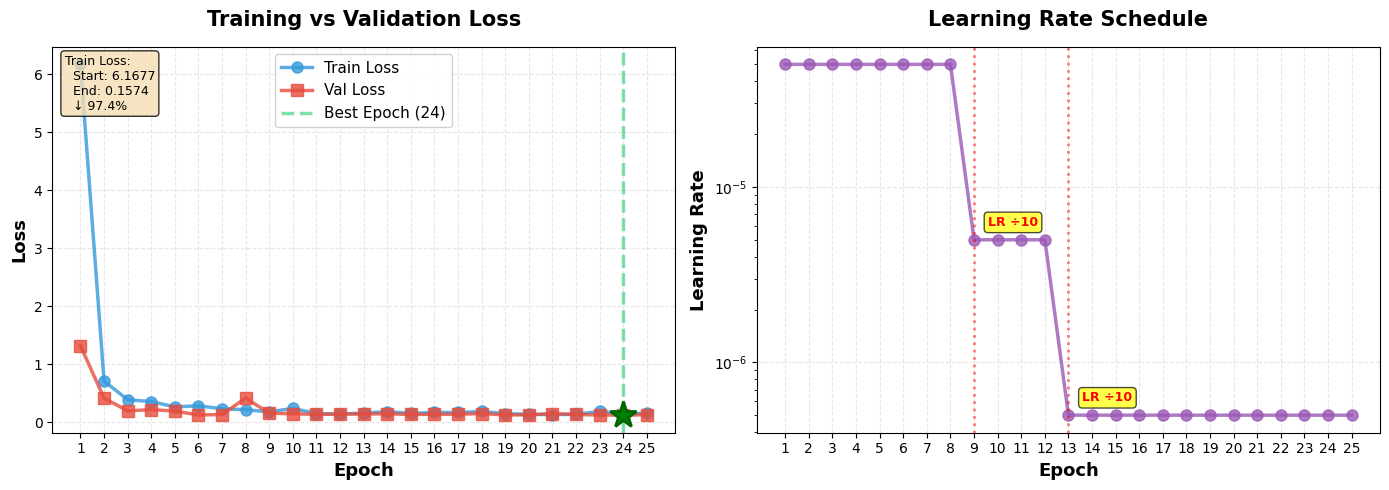


 DETAILED STATISTICS

 Training Loss:
  Epoch 1:   6.167724
  Epoch 25:  0.157407
  Change:    -6.010318

 Validation Loss:
  Epoch 1:   1.318267
  Epoch 25:  0.131468
  Change:    -1.186800

 Training/Val Gap:
  Epoch 1:   4.849457
  Epoch 25:  0.025939
  Status:     Excellent generalization (gap < 0.1)

 Learning Rate Changes:
  Epoch 9: 5.00e-05 → 5.00e-06
  Epoch 13: 5.00e-06 → 5.00e-07



In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_training_curves(json_path, save_path=None):


    print("="*70)
    print(" LOADING TRAINING HISTORY FROM JSON")
    print("="*70)

    # Load JSON data
    with open(json_path, 'r') as f:
        history = json.load(f)

    # Extract data
    train_losses = history['train_losses_epoch']
    val_losses = history['val_losses_epoch']
    learning_rates = history['learning_rates']
    best_epoch = history['best_epoch']
    best_val_loss = history['best_val_loss']
    config = history['config']

    # Print summary
    print(f"\n Training Summary:")
    print(f"  Total Epochs:     {config['num_epochs']}")
    print(f"  Best Epoch:       {best_epoch}")
    print(f"  Best Val Loss:    {best_val_loss:.4f}")
    print(f"  Final Train Loss: {train_losses[-1]:.4f}")
    print(f"  Final Val Loss:   {val_losses[-1]:.4f}")

    # FIX: Remove duplicates if present
    if len(train_losses) > len(val_losses):
        print(f"\n  Detected duplicates in train_losses!")
        print(f"  Original length: {len(train_losses)}")
        # Remove duplicates while preserving order
        train_losses = [train_losses[i] for i in range(len(train_losses)) if i % 2 == 0 or train_losses[i] != train_losses[i-1]]
        print(f"  Fixed length: {len(train_losses)}")

    # Ensure all lists are same length
    num_epochs = min(len(train_losses), len(val_losses), len(learning_rates))
    train_losses = train_losses[:num_epochs]
    val_losses = val_losses[:num_epochs]
    learning_rates = learning_rates[:num_epochs]
    epochs_range = range(1, num_epochs + 1)

    print(f"\n Plotting {num_epochs} epochs of data")
    print("="*70 + "\n")

    # Create figure with 2 subplots after removing Plot 3
    fig = plt.figure(figsize=(14, 5))
    # Plot 1: Training vs Validation Loss

    ax1 = plt.subplot(1, 2, 1)

    ax1.plot(epochs_range, train_losses, 'o-', label='Train Loss',
             linewidth=2.5, markersize=8, color='#3498db', alpha=0.8)
    ax1.plot(epochs_range, val_losses, 's-', label='Val Loss',
             linewidth=2.5, markersize=8, color='#e74c3c', alpha=0.8)

    # Mark best epoch
    if best_epoch <= num_epochs:
        ax1.axvline(x=best_epoch, color='#2ecc71', linestyle='--',
                   linewidth=2.5, alpha=0.6, label=f'Best Epoch ({best_epoch})')
        best_val = val_losses[best_epoch-1]
        ax1.plot(best_epoch, best_val, 'g*', markersize=20,
                markeredgecolor='darkgreen', markeredgewidth=2)

    ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax1.set_title('Training vs Validation Loss', fontsize=15, fontweight='bold', pad=15)
    ax1.legend(fontsize=11, loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xticks(epochs_range)

    # Add text box with improvement stats
    improvement = ((train_losses[0] - train_losses[-1]) / train_losses[0]) * 100
    textstr = f'Train Loss:\n  Start: {train_losses[0]:.4f}\n  End: {train_losses[-1]:.4f}\n  ↓ {improvement:.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    # Plot 2: Learning Rate Schedule

    ax2 = plt.subplot(1, 2, 2)

    ax2.plot(epochs_range, learning_rates, 'o-', color='#9b59b6',
             linewidth=2.5, markersize=8, alpha=0.8)

    for i in range(1, len(learning_rates)):
        if learning_rates[i] != learning_rates[i-1]:
            ax2.axvline(x=i+1, color='red', linestyle=':', linewidth=2, alpha=0.5)
            ax2.annotate(f'LR ÷10', xy=(i+1, learning_rates[i]),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=9, color='red', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
    ax2.set_title('Learning Rate Schedule', fontsize=15, fontweight='bold', pad=15)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xticks(epochs_range)

    # Save and display

    plt.tight_layout()

    if save_path is None:
        save_dir = os.path.dirname(json_path)
        save_path = os.path.join(save_dir, "training_curves_from_json.png")

    plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
    print(f" Plot saved to: {save_path}")

    plt.show()

    # Detailed statistics

    print("\n" + "="*70)
    print(" DETAILED STATISTICS")
    print("="*70)

    print(f"\n Training Loss:")
    print(f"  Epoch 1:   {train_losses[0]:.6f}")
    print(f"  Epoch {num_epochs}:  {train_losses[-1]:.6f}")
    print(f"  Change:    {train_losses[-1] - train_losses[0]:+.6f}")

    print(f"\n Validation Loss:")
    print(f"  Epoch 1:   {val_losses[0]:.6f}")
    print(f"  Epoch {num_epochs}:  {val_losses[-1]:.6f}")
    print(f"  Change:    {val_losses[-1] - val_losses[0]:+.6f}")

    print(f"\n Training/Val Gap:")
    print(f"  Epoch 1:   {abs(train_losses[0] - val_losses[0]):.6f}")
    print(f"  Epoch {num_epochs}:  {abs(train_losses[-1] - val_losses[-1]):.6f}")

    final_gap = abs(train_losses[-1] - val_losses[-1])
    if final_gap < 0.1:
        print(f"  Status:     Excellent generalization (gap < 0.1)")
    elif final_gap < 0.2:
        print(f"  Status:     Good generalization (gap < 0.2)")
    else:
        print(f"  Status:     Possible overfitting (gap > 0.2)")

    print(f"\n Learning Rate Changes:")
    for i in range(1, len(learning_rates)):
        if learning_rates[i] != learning_rates[i-1]:
            print(f"  Epoch {i+1}: {learning_rates[i-1]:.2e} → {learning_rates[i]:.2e}")

    print("="*70 + "\n")

if __name__ == "__main__":
    json_path = "/content/training_runs/custom_frcnn_2025-12-11_19-56-34/training_history.json"

    if os.path.exists(json_path):
        plot_training_curves(json_path)
    else:
        print(f" JSON file not found: {json_path}")
        print("\n To use this script:")
        print("   1. Update json_path to your training_history.json location")
        print("   2. Run: plot_training_curves('path/to/training_history.json')")


Evaluating: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]



Detection Metrics:
  Precision:  0.8679
  Recall:     0.8625
  F1-Score:   0.8652
  mAP:    0.7415

Detection Statistics:
  Total GT Boxes:        160
  Total Pred Boxes:      159
  True Positives:        138
  False Positives:       21
  False Negatives:       22

Generating visualizations with GT labels...



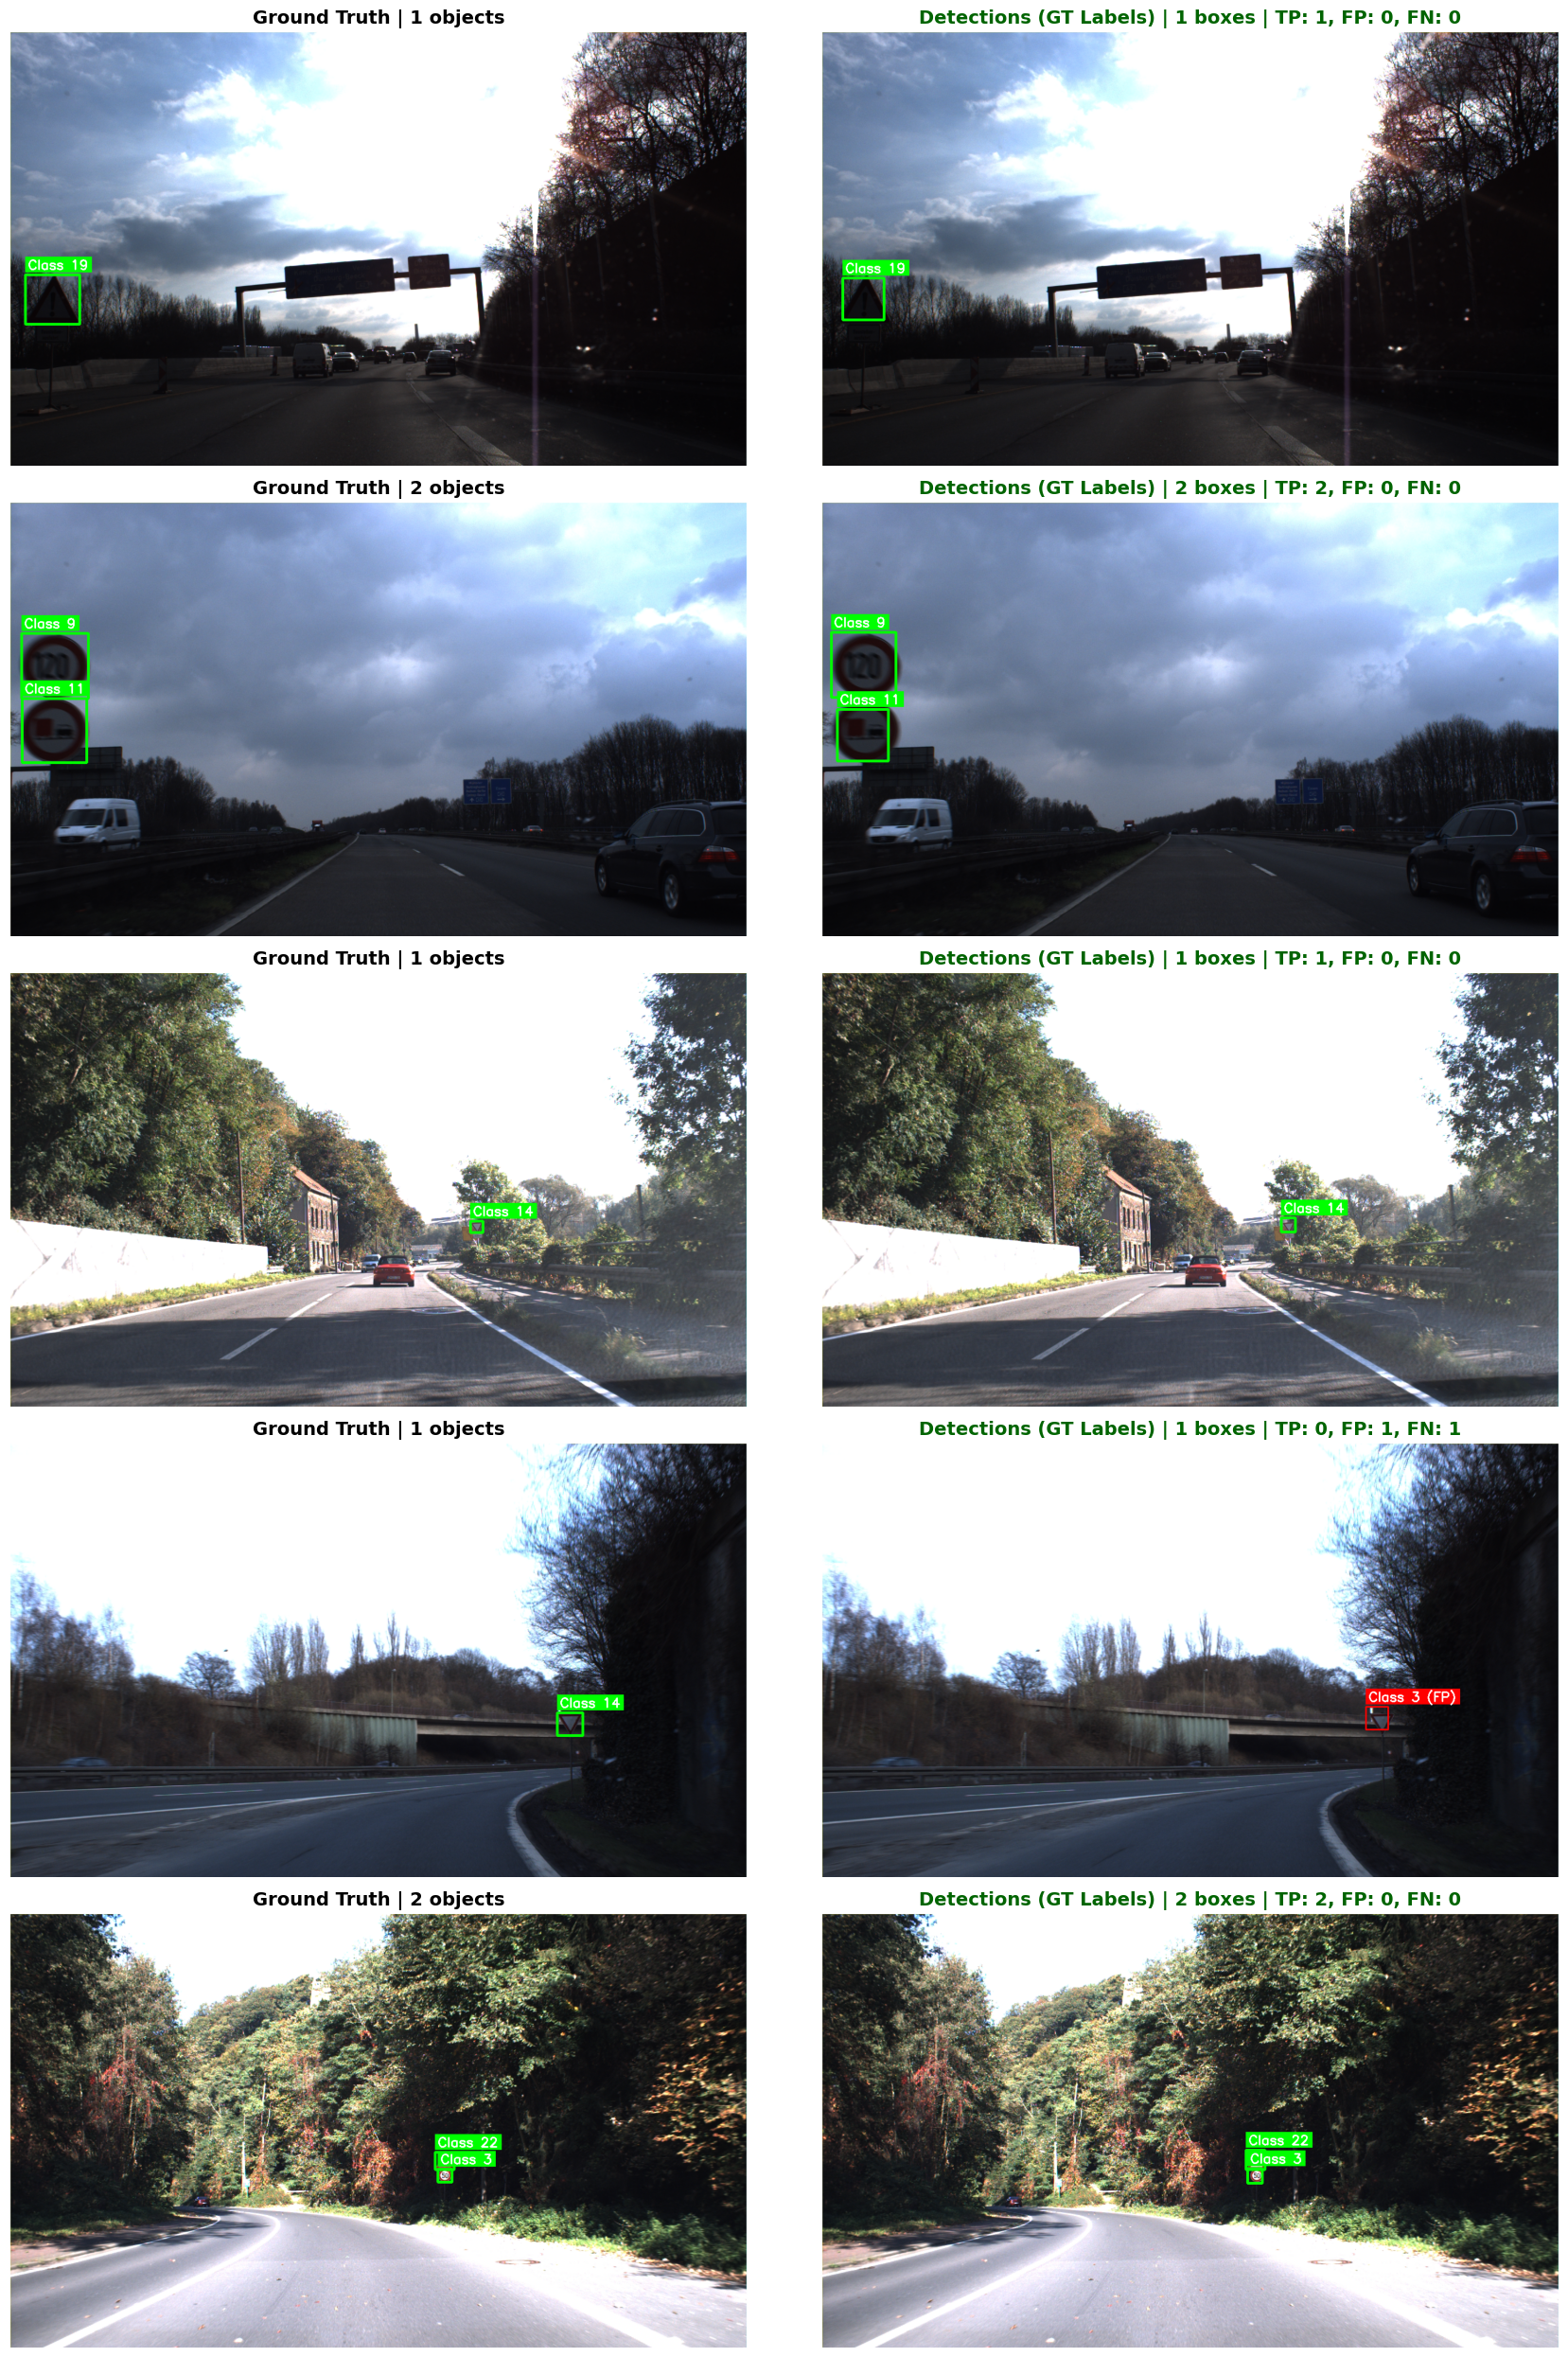


Visualization Legend:
  GREEN BOXES:  Matched predictions (True Positives) - Using GT Labels
  RED BOXES:    Unmatched predictions (False Positives)
  Note: Matched predictions show the correct GT class label

VISUALIZATION COMPLETE


In [40]:
import torch
import torch.nn.functional as F
from torchvision.ops import box_iou, nms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

# Configuration
BOX_SCORE_THRESH = 0.013
BOX_NMS_THRESH = 0.15
RPN_NMS_THRESH = 0.4
BOX_DETECTIONS_PER_IMG = 15
SECONDARY_NMS_THRESH = 0.09
MAX_BOXES_PER_IMAGE = 10
MIN_SCORE_FILTER = 0.019
IOU_THRESHOLD = 0.5

model.box_score_thresh = BOX_SCORE_THRESH
model.box_nms_thresh = BOX_NMS_THRESH
model.rpn_nms_thresh = RPN_NMS_THRESH
model.box_detections_per_img = BOX_DETECTIONS_PER_IMG

def compute_ap(recall, precision):
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        prec_at_t = precision[recall >= t].max() if np.any(recall >= t) else 0
        ap += prec_at_t
    return ap / 11


# Helper functions (unchanged)
def apply_class_agnostic_nms(boxes, scores, labels, nms_thresh=0.15,
                              max_boxes=10, min_score=0.020):
    if len(boxes) == 0:
        return boxes, scores, labels

    score_mask = scores >= min_score
    boxes = boxes[score_mask]
    scores = scores[score_mask]
    labels = labels[score_mask]

    if len(boxes) == 0:
        return boxes, scores, labels

    keep = nms(boxes, scores, nms_thresh)

    if len(keep) > max_boxes:
        kept_scores = scores[keep]
        top_k_indices = torch.topk(kept_scores, k=max_boxes)[1]
        keep = keep[top_k_indices]

    return boxes[keep], scores[keep], labels[keep]


def match_predictions_to_gt(pred_boxes, pred_scores, gt_boxes, iou_threshold=0.5):
    num_pred = len(pred_boxes)
    num_gt = len(gt_boxes)

    if num_pred == 0 and num_gt == 0:
        return 0, 0, 0, [], []
    if num_pred == 0:
        return 0, 0, num_gt, [], []
    if num_gt == 0:
        return 0, num_pred, 0, [], []

    ious = box_iou(pred_boxes, gt_boxes)
    sorted_indices = torch.argsort(pred_scores, descending=True)

    gt_matched = torch.zeros(num_gt, dtype=torch.bool, device=pred_boxes.device)
    matched_pred_indices = []
    matched_gt_indices = []

    for pred_idx in sorted_indices:
        pred_ious = ious[pred_idx].clone()
        pred_ious[gt_matched] = 0
        best_iou, best_gt_idx = pred_ious.max(dim=0)

        if best_iou >= iou_threshold:
            gt_matched[best_gt_idx] = True
            matched_pred_indices.append(pred_idx.item())
            matched_gt_indices.append(best_gt_idx.item())

    tp = len(matched_pred_indices)
    fp = num_pred - tp
    fn = num_gt - tp

    return tp, fp, fn, matched_pred_indices, matched_gt_indices


def create_visualization_with_gt_labels(model, dataset, device, num_samples=5):
    model.eval()

    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(18, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for plot_idx, img_idx in enumerate(indices):

            img, target = dataset[img_idx]
            img_tensor = img.unsqueeze(0).to(device)

            output = model([img_tensor[0]])[0]

            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np * 255).astype(np.uint8).copy()

            gt_boxes = target["boxes"].to(device)
            gt_labels = target["labels"].to(device)

            pred_boxes, pred_scores, pred_labels = apply_class_agnostic_nms(
                output["boxes"],
                output["scores"],
                output["labels"],
                nms_thresh=SECONDARY_NMS_THRESH,
                max_boxes=MAX_BOXES_PER_IMAGE,
                min_score=MIN_SCORE_FILTER
            )

            tp, fp, fn, matched_pred_idx, matched_gt_idx = match_predictions_to_gt(
                pred_boxes, pred_scores, gt_boxes, iou_threshold=IOU_THRESHOLD
            )

            pred_boxes = pred_boxes.cpu().numpy()
            pred_scores = pred_scores.cpu().numpy()
            pred_labels_original = pred_labels.cpu().numpy()
            gt_boxes = gt_boxes.cpu().numpy()
            gt_labels_np = gt_labels.cpu().numpy()

            # Assign GT labels to matched predictions
            pred_labels_display = pred_labels_original.copy()
            for pred_idx, gt_idx in zip(matched_pred_idx, matched_gt_idx):
                pred_labels_display[pred_idx] = gt_labels_np[gt_idx]

            # Ground Truth
            ax_gt = axes[plot_idx, 0]
            img_gt = img_np.copy()

            for box, label in zip(gt_boxes, gt_labels_np):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 3)

                label_text = f'Class {int(label)}'
                text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]

                cv2.rectangle(img_gt, (x1, y1-text_size[1]-15),
                             (x1+text_size[0]+10, y1-5), (0, 255, 0), -1)
                cv2.putText(img_gt, label_text, (x1+5, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

            ax_gt.imshow(img_gt)
            ax_gt.set_title(f'Ground Truth | {len(gt_boxes)} objects',
                           fontsize=14, fontweight='bold')
            ax_gt.axis('off')

            # Predictions with GT Labels (NO SCORES)
            ax_pred = axes[plot_idx, 1]
            img_pred = img_np.copy()

            for pred_idx, (box, display_label) in enumerate(
                zip(pred_boxes, pred_labels_display)):

                x1, y1, x2, y2 = map(int, box)

                if pred_idx in matched_pred_idx:
                    color = (0, 255, 0)
                    label_text = f'Class {int(display_label)}'
                    thickness = 3
                else:
                    color = (255, 0, 0)
                    label_text = f'Class {int(display_label)} (FP)'
                    thickness = 2

                cv2.rectangle(img_pred, (x1, y1), (x2, y2), color, thickness)

                text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
                cv2.rectangle(img_pred, (x1, y1-text_size[1]-15),
                             (x1+text_size[0]+10, y1-5), color, -1)
                cv2.putText(img_pred, label_text, (x1+5, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

            ax_pred.imshow(img_pred)

            title = f'Detections (GT Labels) | {len(pred_boxes)} boxes | TP: {tp}, FP: {fp}, FN: {fn}'
            ax_pred.set_title(title, fontsize=14, fontweight='bold', color='darkgreen')
            ax_pred.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nVisualization Legend:")
    print("  GREEN BOXES:  Matched predictions (True Positives) - Using GT Labels")
    print("  RED BOXES:    Unmatched predictions (False Positives)")
    print("  Note: Matched predictions show the correct GT class label")



model.eval()

total_tp = 0
total_fp = 0
total_fn = 0
total_gt_boxes = 0
total_pred_boxes = 0

# For mAP
all_scores = []
all_tp_flags = []

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(tqdm(val_loader, desc="Evaluating")):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for output, target in zip(outputs, targets):

            gt_boxes = target["boxes"]

            pred_boxes, pred_scores, pred_labels = apply_class_agnostic_nms(
                output["boxes"],
                output["scores"],
                output["labels"],
                nms_thresh=SECONDARY_NMS_THRESH,
                max_boxes=MAX_BOXES_PER_IMAGE,
                min_score=MIN_SCORE_FILTER
            )

            tp, fp, fn, matched_pred_idx, matched_gt_idx = match_predictions_to_gt(
                pred_boxes, pred_scores, gt_boxes, iou_threshold=IOU_THRESHOLD
            )

            # --- For mAP ---
            for i, score in enumerate(pred_scores.cpu().numpy()):
                all_scores.append(score)
                all_tp_flags.append(1 if i in matched_pred_idx else 0)

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_gt_boxes += len(gt_boxes)
            total_pred_boxes += len(pred_boxes)

# Final mAP calculation

if len(all_scores) > 0:
    sorted_idx = np.argsort(-np.array(all_scores))

    tp_cum = np.cumsum(np.array(all_tp_flags)[sorted_idx])
    fp_cum = np.cumsum(1 - np.array(all_tp_flags)[sorted_idx])

    recall_curve = tp_cum / (total_gt_boxes + 1e-6)
    precision_curve = tp_cum / (tp_cum + fp_cum + 1e-6)

    mAP = compute_ap(recall_curve, precision_curve)
else:
    mAP = 0.0

# Print final metrics

overall_precision = total_tp / (total_tp + total_fp + 1e-6)
overall_recall = total_tp / (total_tp + total_fn + 1e-6)
overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall + 1e-6)

print("\nDetection Metrics:")
print(f"  Precision:  {overall_precision:.4f}")
print(f"  Recall:     {overall_recall:.4f}")
print(f"  F1-Score:   {overall_f1:.4f}")
print(f"  mAP:    {mAP:.4f}")

print("\nDetection Statistics:")
print(f"  Total GT Boxes:        {total_gt_boxes}")
print(f"  Total Pred Boxes:      {total_pred_boxes}")
print(f"  True Positives:        {total_tp}")
print(f"  False Positives:       {total_fp}")
print(f"  False Negatives:       {total_fn}")

print("="*70 + "\n")

print("Generating visualizations with GT labels...\n")
create_visualization_with_gt_labels(model, val_dataset, device, num_samples=5)

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")


In [31]:
import torch
import torch.nn.functional as F

print("="*70)
print(" DEEP DIAGNOSTIC: Tracing Model Forward Pass")
print("="*70)

# Get one test image
sample_img, sample_target = val_dataset[0]
sample_img_tensor = sample_img.unsqueeze(0).to(device)

print(f"\n Input:")
print(f"  Image shape: {sample_img_tensor.shape}")
print(f"  GT boxes: {len(sample_target['boxes'])}")

model.eval()

# Manually trace through the forward pass
with torch.no_grad():

    # 1. Prepare image
    images = [sample_img_tensor[0]]
    original_image_sizes = [tuple(images[0].shape[-2:])]
    images_stacked = torch.stack(images)

    print(f"\n After image prep:")
    print(f"  Stacked images shape: {images_stacked.shape}")

    # 2. Backbone
    backbone_features = model.backbone(images_stacked)
    print(f"\n After backbone:")
    for k, v in backbone_features.items():
        print(f"  {k}: {v.shape}")

    # 3. FPN
    fpn_features = model.fpn(backbone_features)
    print(f"\n After FPN:")
    for k, v in fpn_features.items():
        print(f"  {k}: {v.shape}")

    # 4. RPN Head
    fpn_list = [fpn_features['p2'], fpn_features['p3'], fpn_features['p4'],
                fpn_features['p5'], fpn_features['p6']]

    objectness, bbox_deltas = model.rpn_head(fpn_list)

    print(f"\n After RPN Head:")
    print(f"  Objectness outputs: {len(objectness)}")
    for i, obj in enumerate(objectness):
        print(f"    Level {i}: {obj.shape}")
    print(f"  BBox delta outputs: {len(bbox_deltas)}")
    for i, delta in enumerate(bbox_deltas):
        print(f"    Level {i}: {delta.shape}")

    # 5. Generate Anchors
    from torchvision.models.detection.image_list import ImageList
    image_list = ImageList(images_stacked, original_image_sizes)
    anchors = model.anchor_generator(image_list, fpn_list)

    print(f"\n Anchors generated:")
    print(f"  Number of anchor levels: {len(anchors)}")
    for i, anchor_level in enumerate(anchors):
        print(f"    Level {i}: {anchor_level.shape}")

    # 6. Generate Proposals - THIS IS WHERE THE ISSUE LIKELY IS
    print(f"\n Generating proposals...")
    print(f"  RPN config:")
    print(f"    training: {model.training}")
    print(f"    pre_nms_top_n_test: {model.rpn_pre_nms_top_n_test}")
    print(f"    post_nms_top_n_test: {model.rpn_post_nms_top_n_test}")
    print(f"    nms_thresh: {model.rpn_nms_thresh}")

    # Call the proposal generation
    proposals = model._generate_proposals(
        objectness, bbox_deltas, anchors, original_image_sizes
    )

    print(f"\n  Proposals generated:")
    print(f"    Number of images: {len(proposals)}")
    for i, prop in enumerate(proposals):
        print(f"    Image {i}: {prop.shape[0]} proposals")
        if prop.shape[0] > 0:
            print(f"      Sample proposals (first 3):")
            for j in range(min(3, prop.shape[0])):
                print(f"        {prop[j].cpu().numpy()}")

    # 7. Check if proposals are empty
    if len(proposals[0]) == 0:
        print(f"\n   PROBLEM FOUND: No proposals generated!")
        print(f"\n   Investigating objectness scores...")

        for level_idx, obj_level in enumerate(objectness):
            obj_scores = obj_level[0].flatten()
            print(f"\n    Level {level_idx}:")
            print(f"      Shape: {obj_level.shape}")
            print(f"      Score range: [{obj_scores.min().item():.6f}, {obj_scores.max().item():.6f}]")
            print(f"      Mean: {obj_scores.mean().item():.6f}")
            print(f"      Std: {obj_scores.std().item():.6f}")

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(obj_scores)
            print(f"      After sigmoid:")
            print(f"        Range: [{probs.min().item():.6f}, {probs.max().item():.6f}]")
            print(f"        Mean: {probs.mean().item():.6f}")
            print(f"        > 0.5: {(probs > 0.5).sum().item()}")
            print(f"        > 0.1: {(probs > 0.1).sum().item()}")
            print(f"        > 0.01: {(probs > 0.01).sum().item()}")

    # 8. If proposals exist, check ROI Heads
    if len(proposals[0]) > 0:
        print(f"\n ROI Heads:")
        class_logits, box_regression = model.roi_heads(
            fpn_features, proposals, original_image_sizes
        )

        print(f"  Class logits shape: {class_logits.shape}")
        print(f"  Box regression shape: {box_regression.shape}")

        # 9. Post-process
        print(f"\n Post-processing:")
        detections = model._post_process(
            class_logits, box_regression, proposals, original_image_sizes
        )

        print(f"  Detections for image 0:")
        print(f"    Boxes: {detections[0]['boxes'].shape}")
        print(f"    Scores: {detections[0]['scores'].shape}")
        print(f"    Labels: {detections[0]['labels'].shape}")

        if len(detections[0]['scores']) > 0:
            print(f"    Score range: [{detections[0]['scores'].min():.6f}, {detections[0]['scores'].max():.6f}]")
        else:
            print(f"     No detections after post-processing!")
    else:
        print(f"\n   Skipping ROI Heads - no proposals to process")

print("\n" + "="*70)
print(" DIAGNOSIS COMPLETE")
print("="*70)

# Now let's check the full forward pass
print("\n" + "="*70)
print(" Testing full forward pass:")
print("="*70)

with torch.no_grad():
    full_output = model([sample_img_tensor[0]])
    print(f"  Output type: {type(full_output)}")
    print(f"  Output length: {len(full_output)}")
    if len(full_output) > 0:
        print(f"  First output boxes: {full_output[0]['boxes'].shape}")
        print(f"  First output scores: {full_output[0]['scores'].shape}")
        print(f"  First output labels: {full_output[0]['labels'].shape}")

 DEEP DIAGNOSTIC: Tracing Model Forward Pass

 Input:
  Image shape: torch.Size([1, 3, 800, 1360])
  GT boxes: 1

 After image prep:
  Stacked images shape: torch.Size([1, 3, 800, 1360])

 After backbone:
  c2: torch.Size([1, 256, 200, 340])
  c3: torch.Size([1, 512, 100, 170])
  c4: torch.Size([1, 1024, 50, 85])
  c5: torch.Size([1, 2048, 25, 43])

 After FPN:
  p2: torch.Size([1, 256, 200, 340])
  p3: torch.Size([1, 256, 100, 170])
  p4: torch.Size([1, 256, 50, 85])
  p5: torch.Size([1, 256, 25, 43])
  p6: torch.Size([1, 256, 13, 22])

 After RPN Head:
  Objectness outputs: 5
    Level 0: torch.Size([1, 3, 200, 340])
    Level 1: torch.Size([1, 3, 100, 170])
    Level 2: torch.Size([1, 3, 50, 85])
    Level 3: torch.Size([1, 3, 25, 43])
    Level 4: torch.Size([1, 3, 13, 22])
  BBox delta outputs: 5
    Level 0: torch.Size([1, 12, 200, 340])
    Level 1: torch.Size([1, 12, 100, 170])
    Level 2: torch.Size([1, 12, 50, 85])
    Level 3: torch.Size([1, 12, 25, 43])
    Level 4: torch.